# Review of exercise 5

(c) 2016 Justin Bois and Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

*This exercise was generated from a Jupyter notebook.  You can download the notebook [here](e05.ipynb).*

In [2]:
# Our numerical workhorse.
import numpy as np
import scipy.optimize

# Modules for plotting
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()

# Modules for image processing
import skimage.io
import skimage.morphology
import skimage.segmentation
import skimage.measure


# Modules for interacting with our file system. 
import os
import glob

# Used for rending plots in the notebook
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

## Problem 5.1: Growth curves from a movie

At the dawn of the molecular revolution in biology, key experiments by Jacques Monod in which he measured growth curves of bacteria under different conditions exposed some of the mechanisms of regulation of gene expression.  Those growth curves were measured in a bulk solution..  In this exercise, we will measure bacterial growth starting from a *two bacteria*.  The movie shows *Bacillus subtilis* constitutively expressing mCherry growing under slow growth conditions.  These data were kindly donated by Jin Park from the Elowitz lab here at Caltech.

**a)** Load in the series of images contained in the directory `data/bacterial_growth/`. Be sure that however you store them (a list or tuple or other object) has the frames in the proper order.

**b)** Segment the images to separate bacteria from background.  You do not need to segment individual bacteria; this would likely require some more advanced techniques involving edge detection that we haven't covered in bootcamp.

**c)** Show a representative image from the stack (with the segmentation overlayed in green) of images with a 10 µm scale bar burned in.

**d)** Plot a growth curve for this growing colony.  What values should be on the $y$-axis?  (This is one of those times where I ask an open question for which there is no "right" answer.)

**e)** Perform a regression on this growth curve to estimate the time constant for the exponential growth.  Be sure to check out the `README` file in the directory containing the images to get the appropriate metadata.

### Problem 5.1: solution

**a)** We will load the images into a tuple, where the index of the tuple corresponds to the frame number.  Under normal circumstances, we would do data validation to make sure there are no skipped frames, but in the interest of brevity, we will proceed assuming all data are properly labeled and organized.

In [3]:
# Initialize list of images
ims = []

# Read each image into memory
for fname in glob.glob('data/bacterial_growth/bacillus_*.tif'):
    ims.append(skimage.io.imread(fname))
    
# Store it as a tuple so we don't mess with it
ims = tuple(ims)

# How many?
print('There are', len(ims), 'images.')

There are 55 images.


Let's take a quick look at a few of the images.  We'll look at frames `0`, `15`, `30`, and `45`.

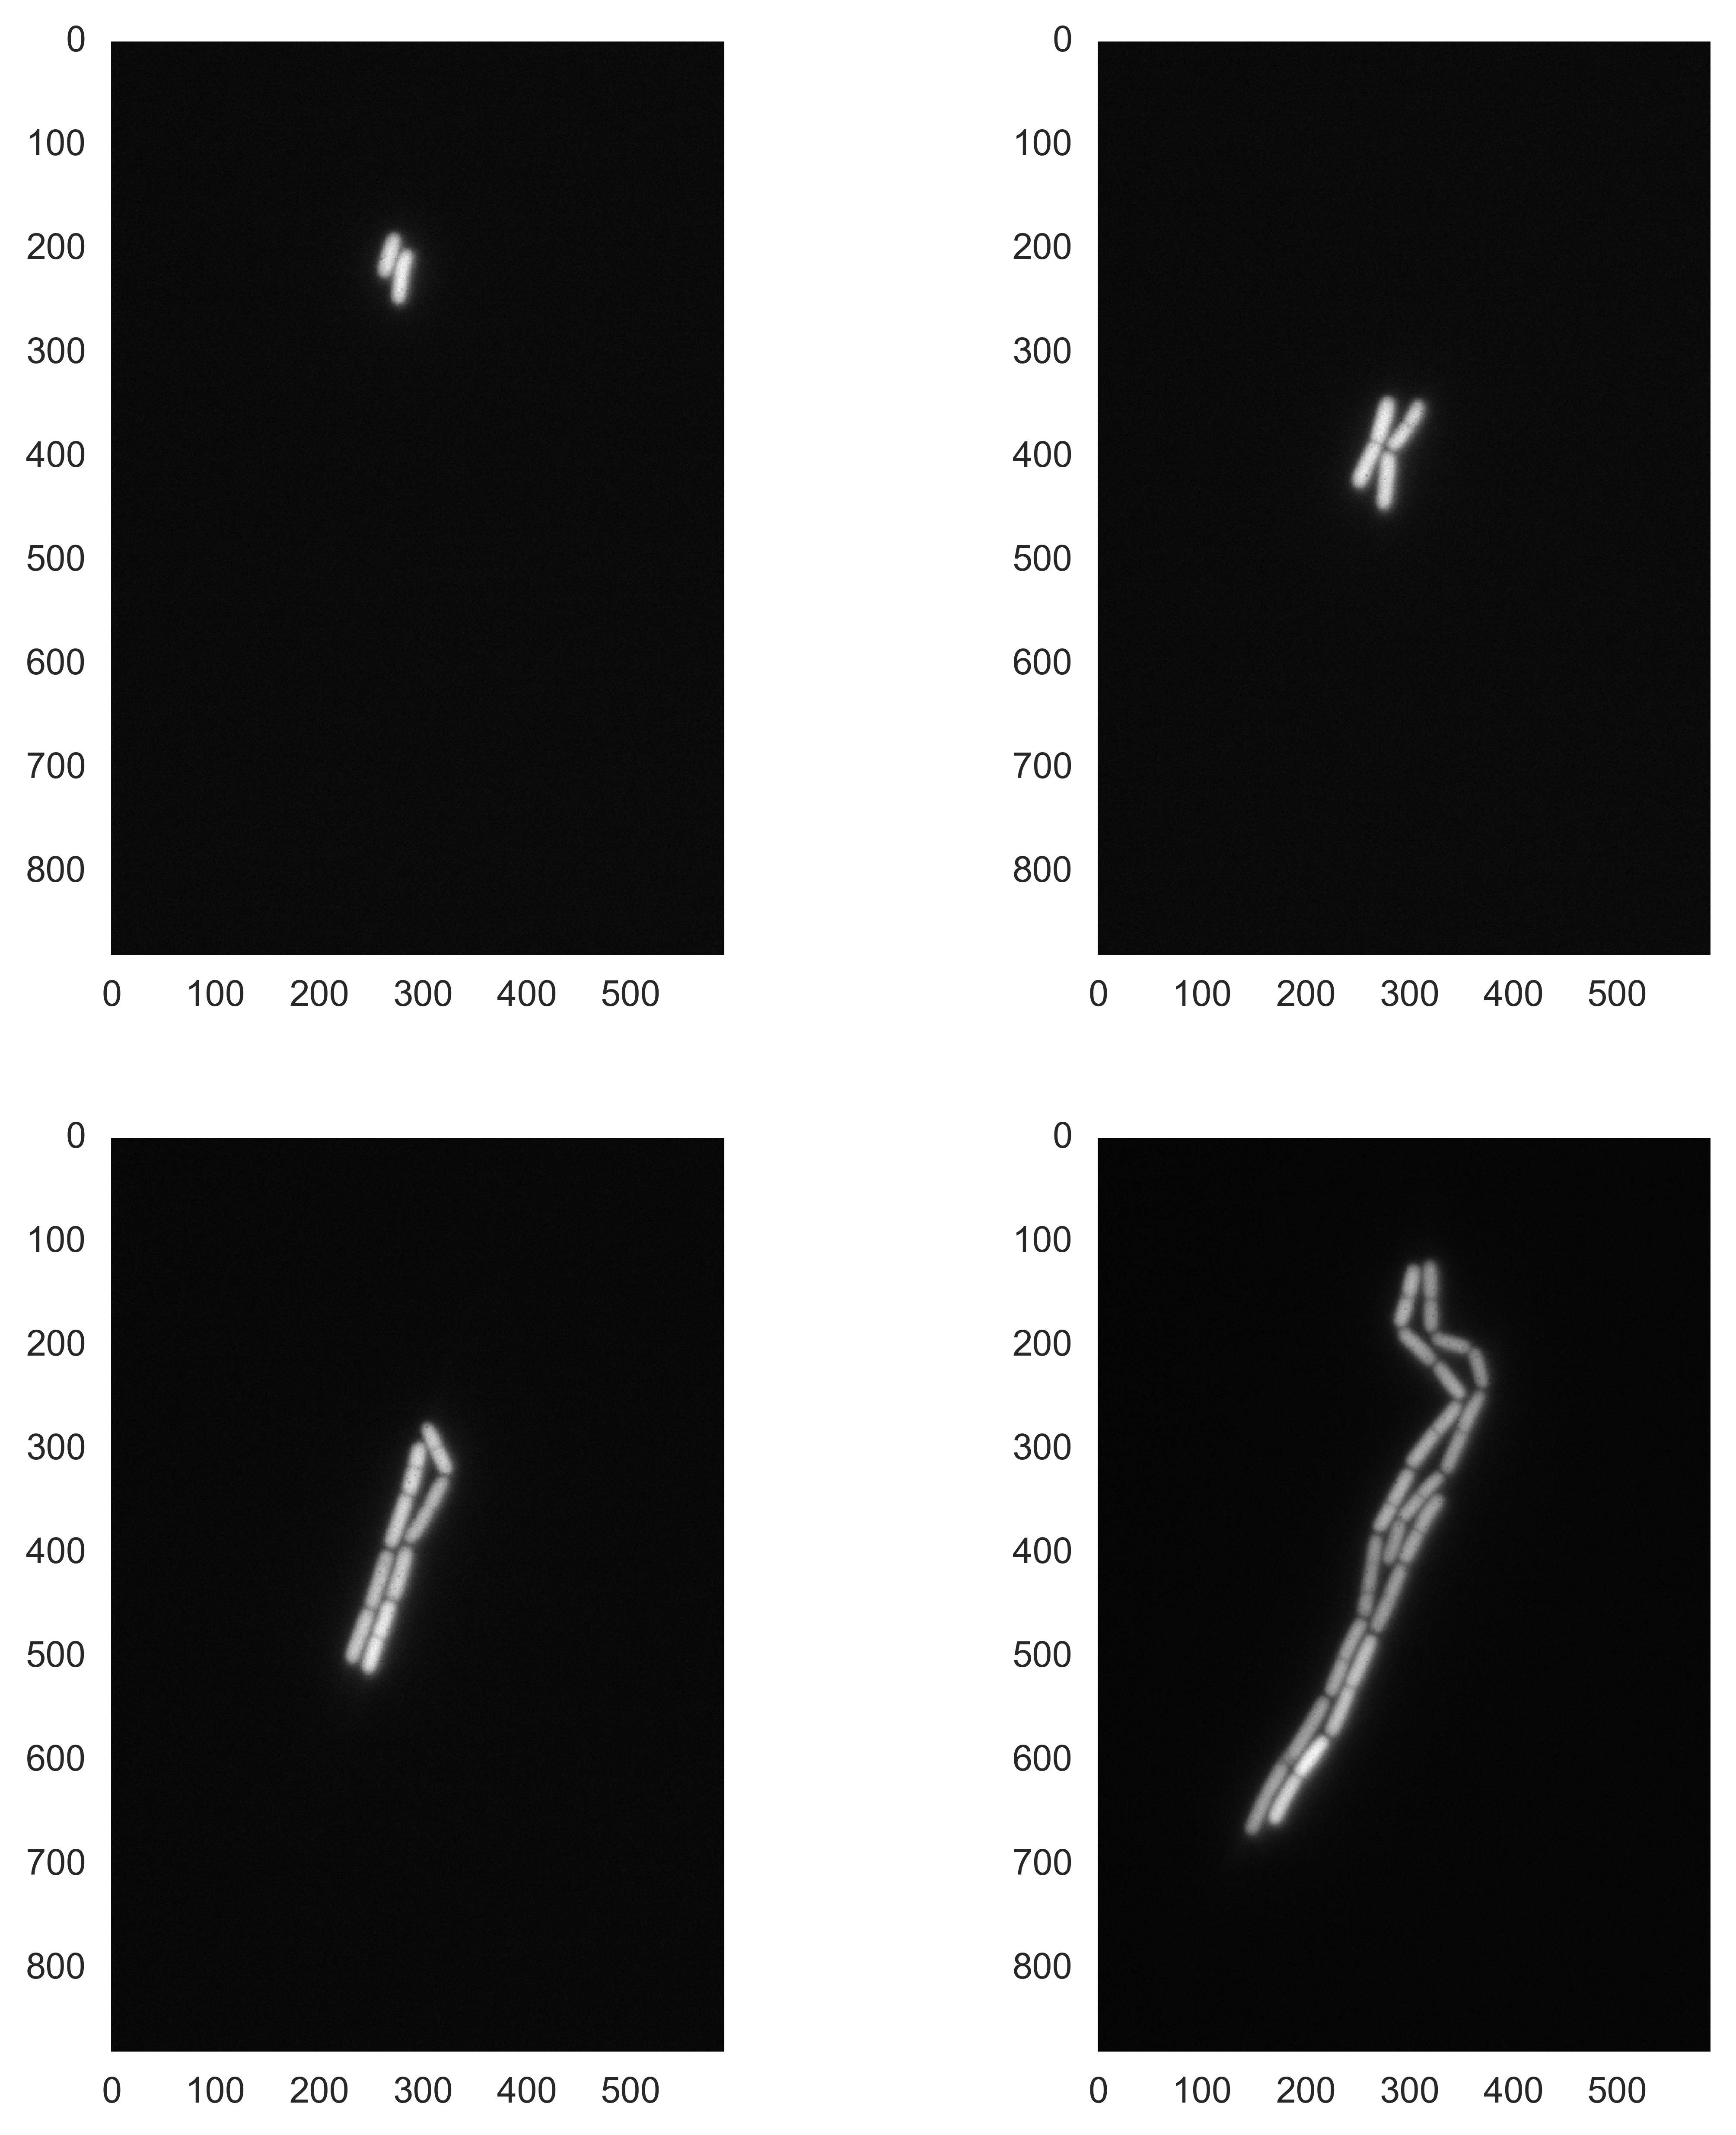

In [19]:
# Display phase and thresholded image
with sns.axes_style('dark'):
    fig, ax = plt.subplots(2, 2, figsize=(9, 10))
    ax[0,0].imshow(ims[0], cmap=plt.cm.gray)
    ax[0,1].imshow(ims[15], cmap=plt.cm.gray)
    ax[1,0].imshow(ims[30], cmap=plt.cm.gray)
    ax[1,1].imshow(ims[45], cmap=plt.cm.gray)

**b)** We will take a similar approach as in [Lesson 38](l38_intro_to_image_processing.html) to segment the image.  We will simply threshold the image using Otsu's method.

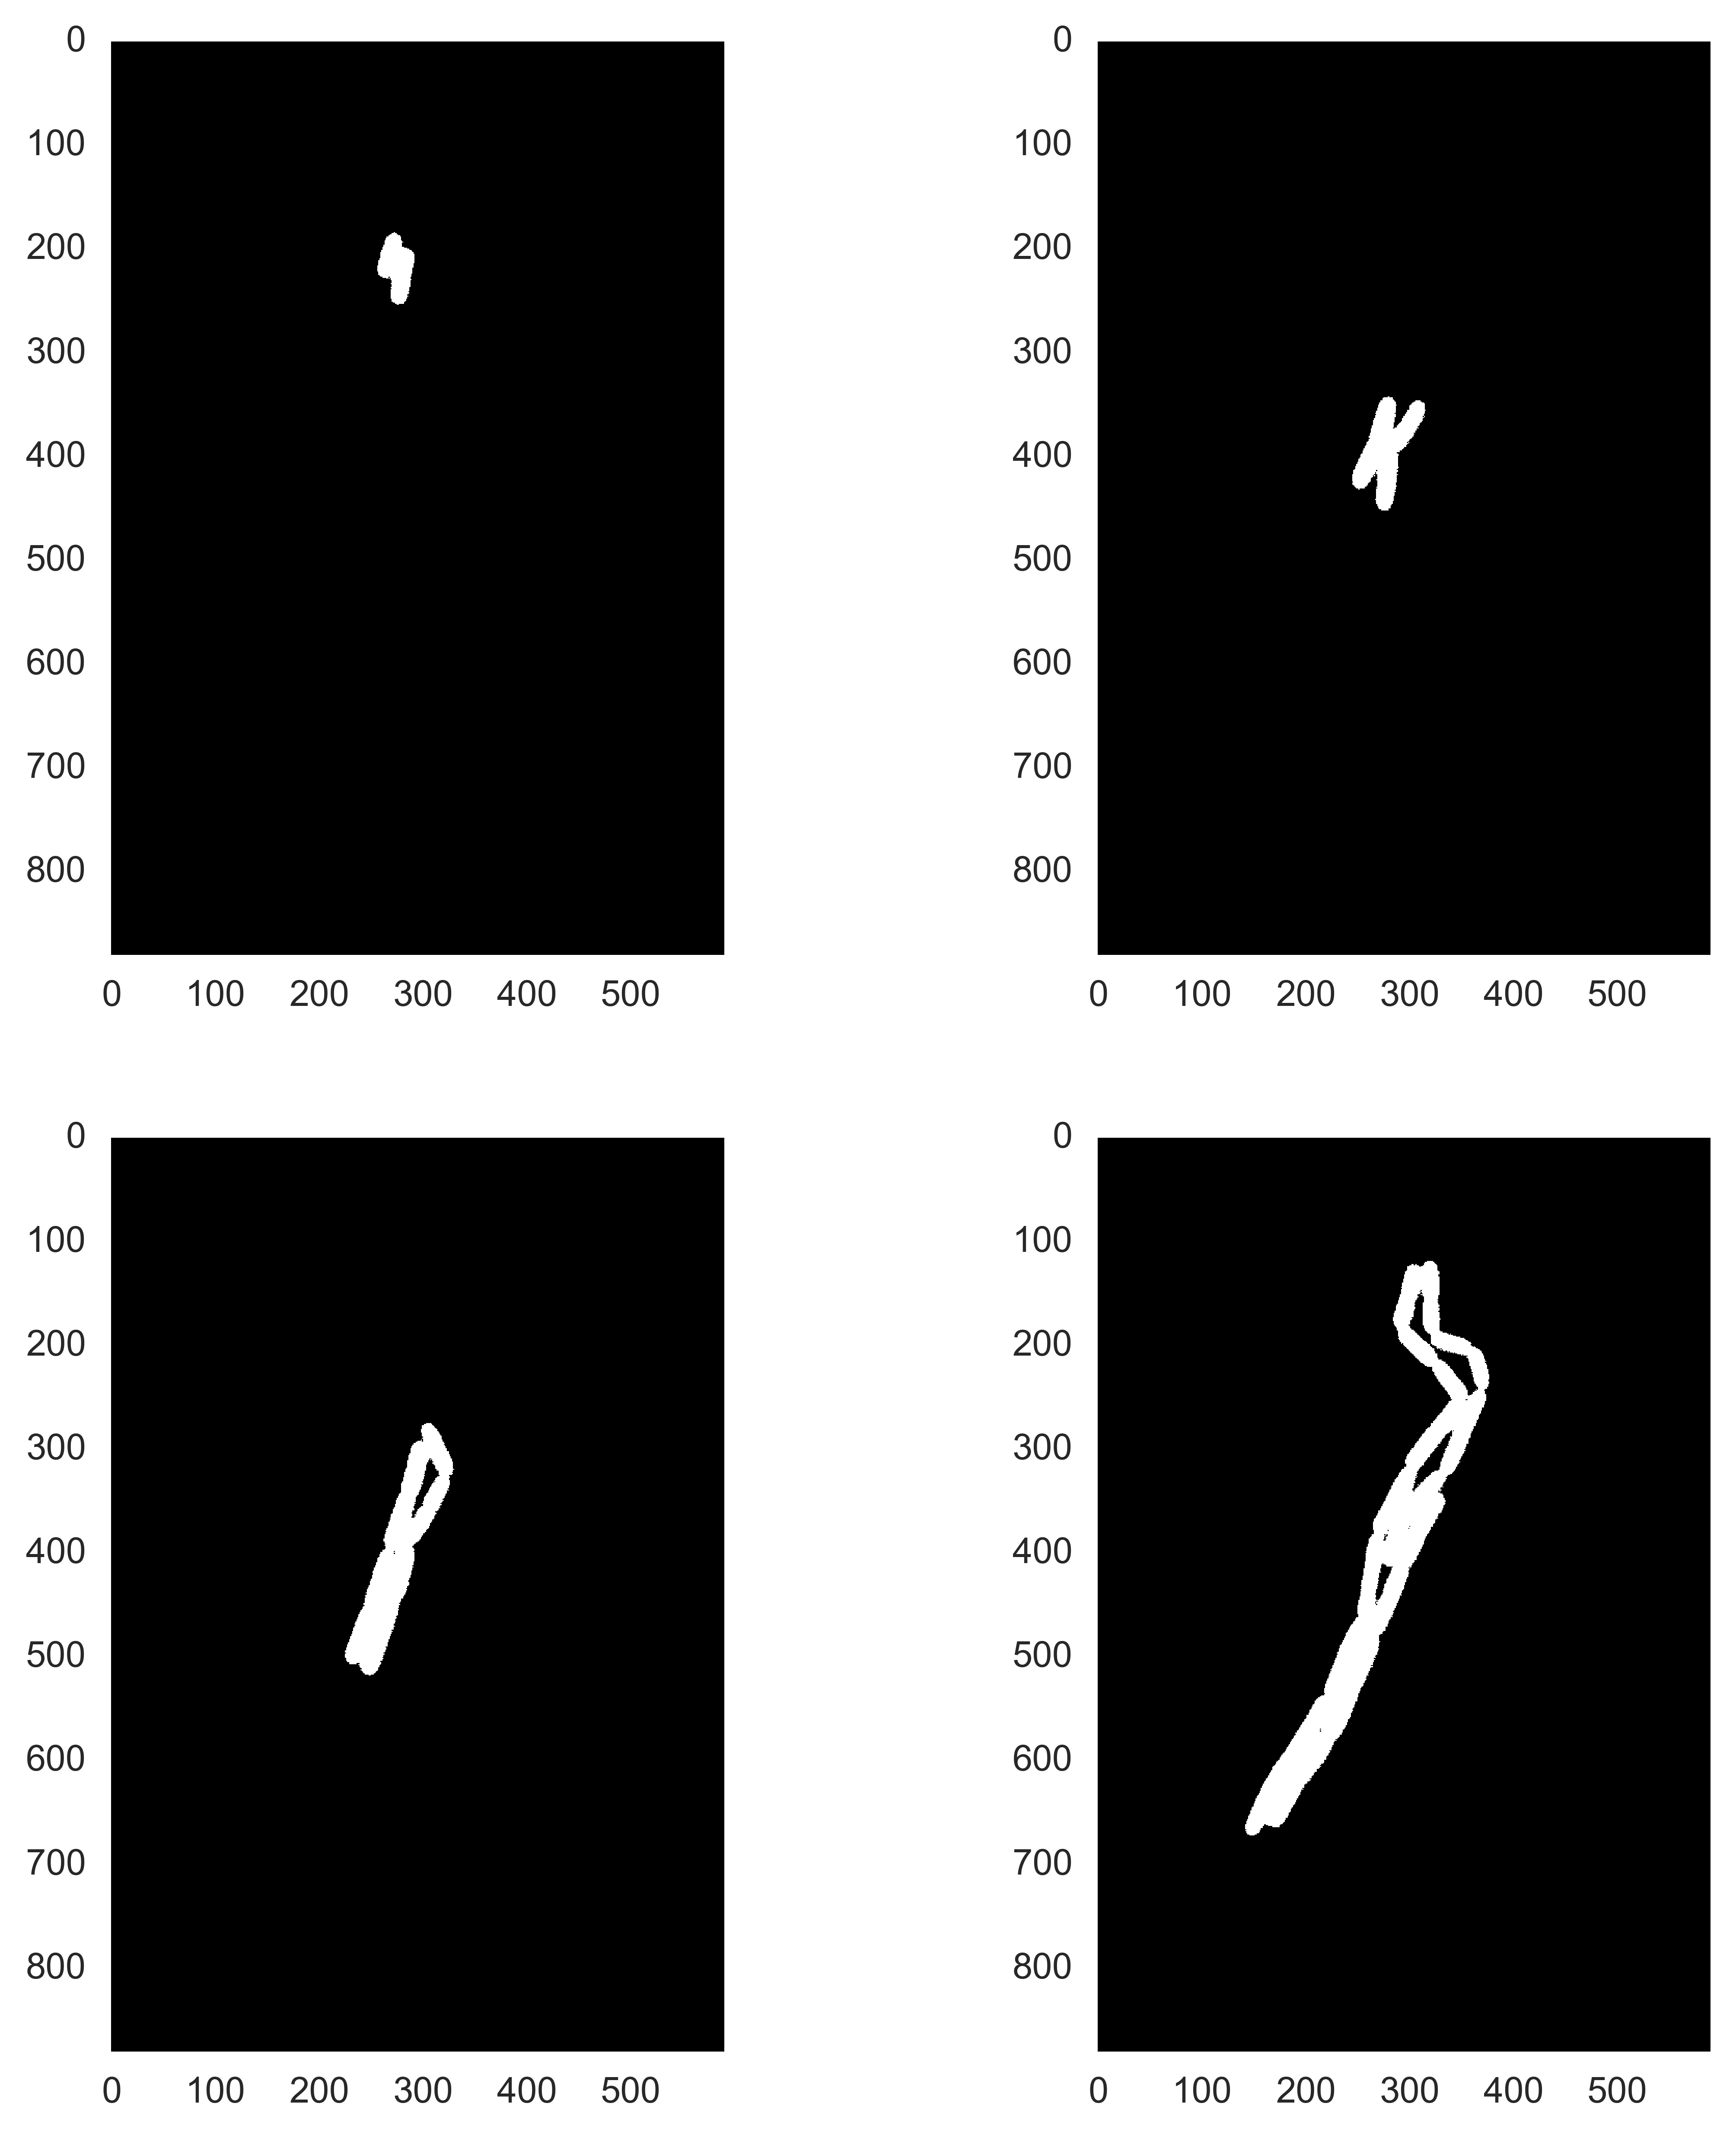

In [20]:
# Initialize list of thresholded images
ims_bw = [None] * len(ims)

# Threshold the images
for i, im in enumerate(ims):
    thresh = skimage.filters.threshold_otsu(im)
    ims_bw[i] = im > thresh
    
# Take a look at the result
with sns.axes_style('dark'):
    fig, ax = plt.subplots(2, 2, figsize=(9, 10))
    ax[0,0].imshow(ims_bw[0], cmap=plt.cm.gray)
    ax[0,1].imshow(ims_bw[15], cmap=plt.cm.gray)
    ax[1,0].imshow(ims_bw[30], cmap=plt.cm.gray)
    ax[1,1].imshow(ims_bw[45], cmap=plt.cm.gray)

This is pretty good.  Certainly good enough for generating a growth curve.

**c)** We will overlay the segmentation on image 40.  We'll use the green channel.  To burn in the scale bar, we remember that images are stored as NumPy arrays.  In looking at the README file associated with the images, the interpixel distance is 64.5 nm.  So, we need the scale bar to be $10 / 0.0645 = 155$ pixels long.  We will burn it in the lower right corner.

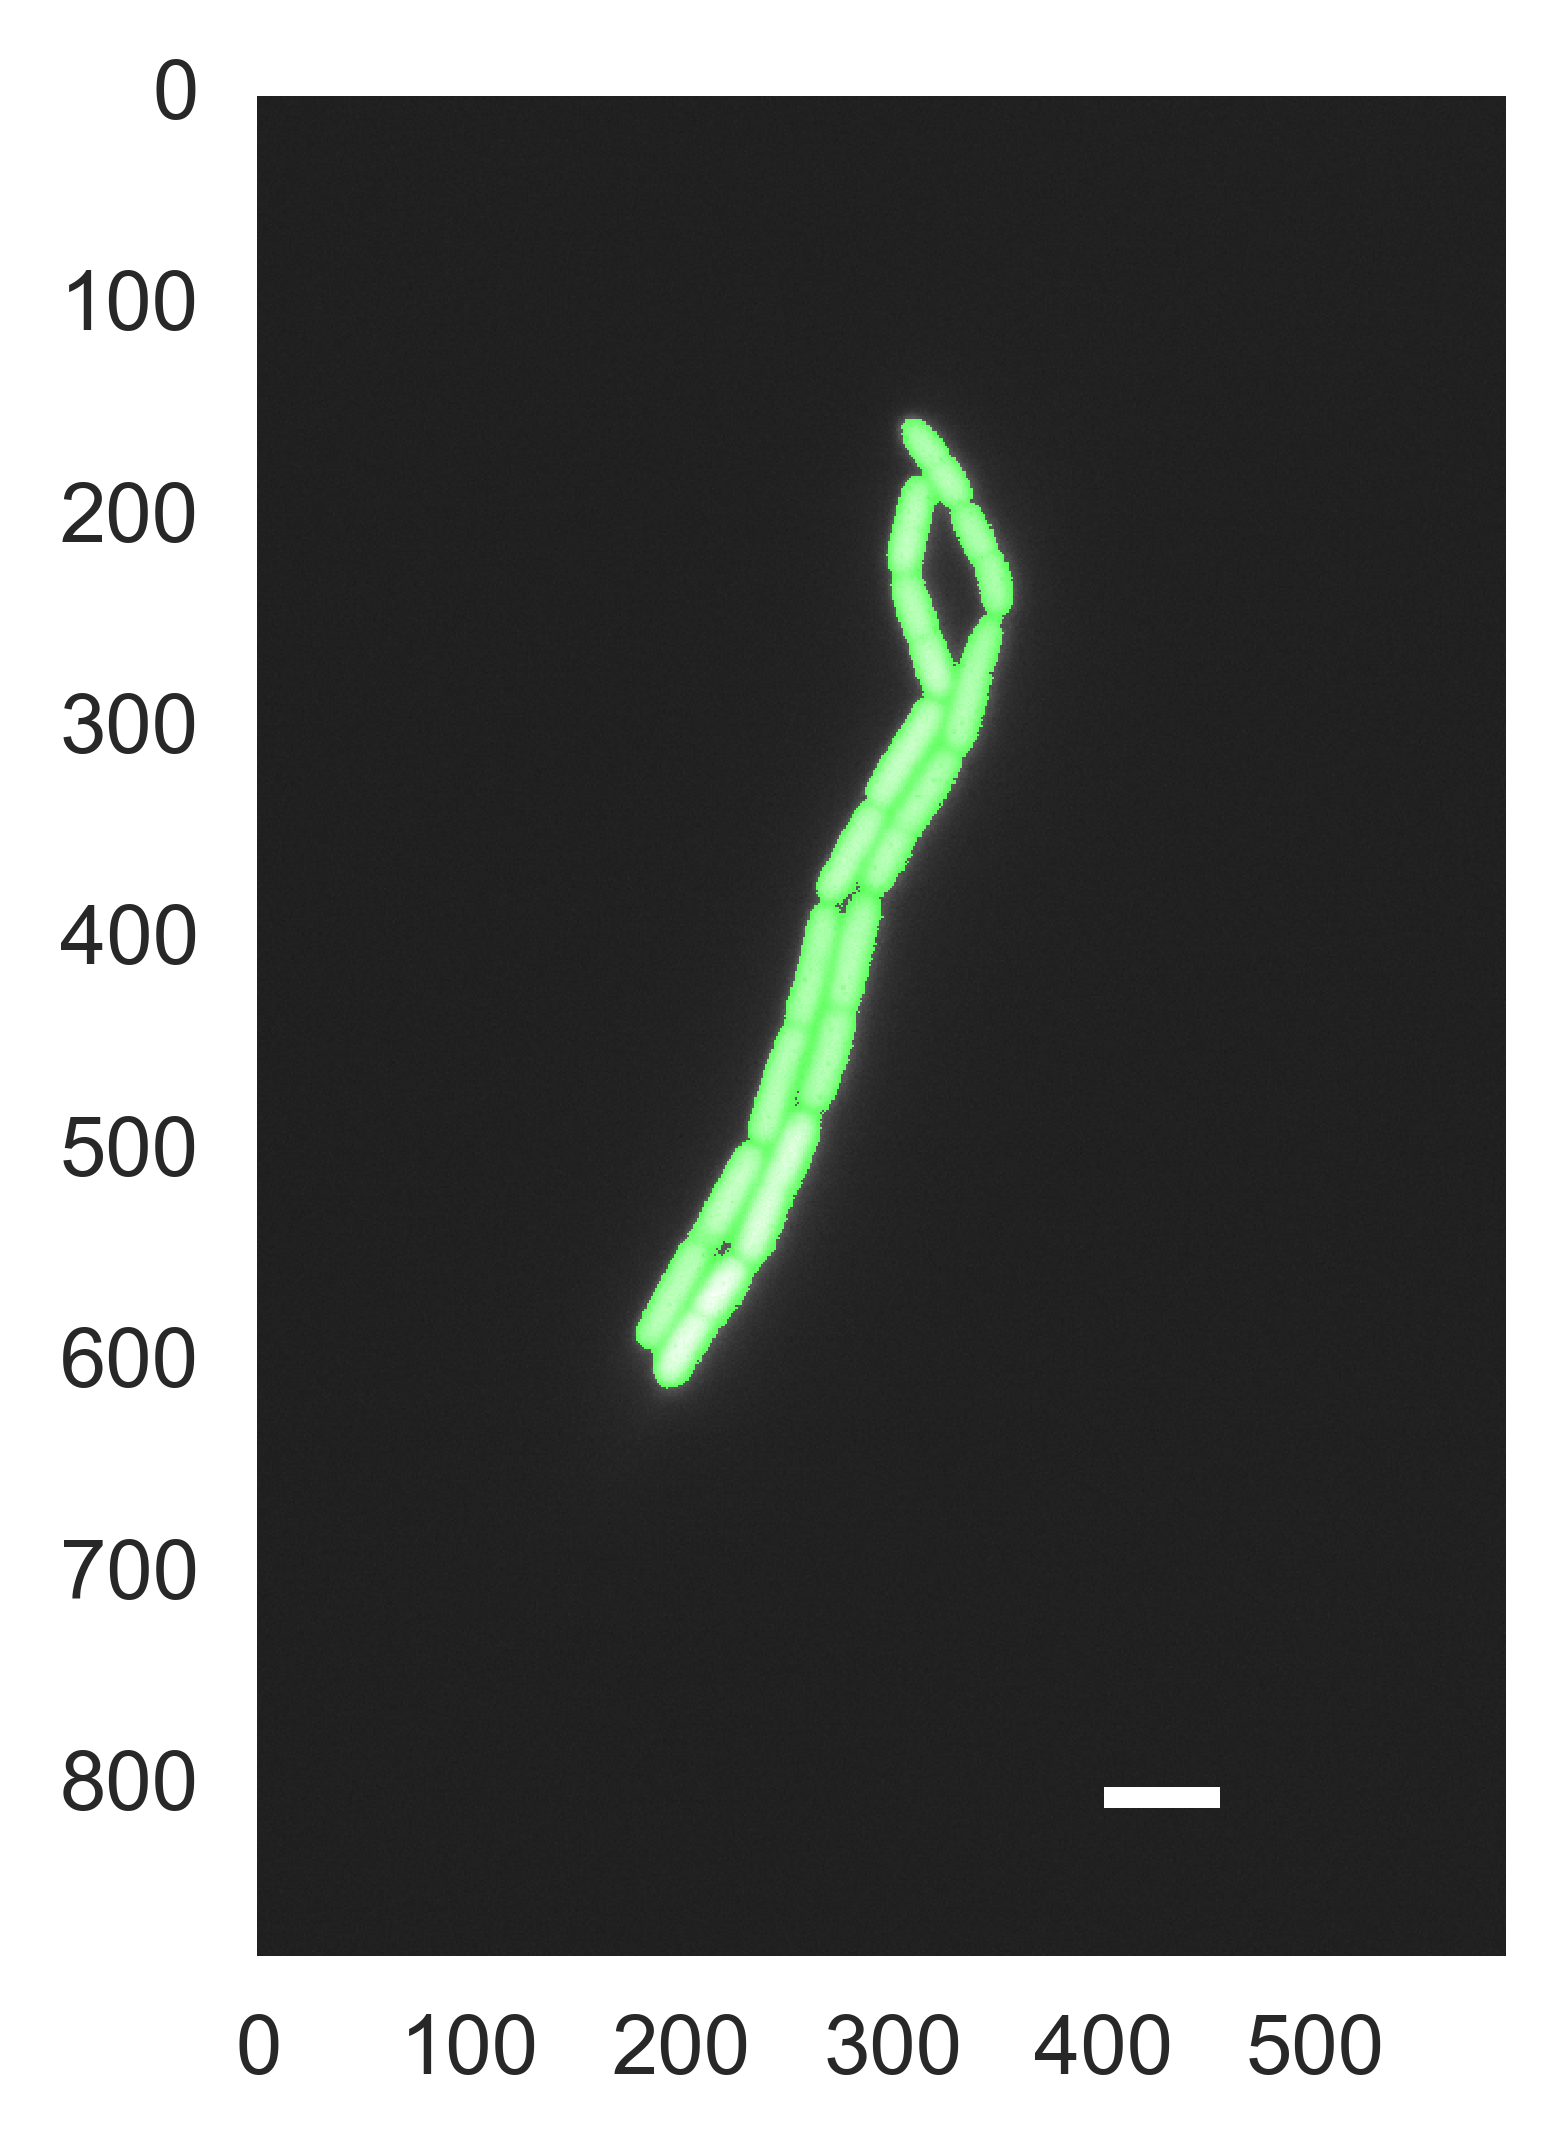

In [21]:
# Image to use, and normalize
im = np.copy(ims[40]).astype(float)
im /= im.max()

# Burn scale bar
im[800:810, 400:455] = 1.0

# Build RGB image by stacking grayscale images
im_rgb = np.dstack(3 * [im / im.max()])

# Saturate red channel wherever there are white pixels in thresh image
im_rgb[ims_bw[40], 1] = 1.0

# Show the result
with sns.axes_style('dark'):
    plt.imshow(im_rgb)

The segmentation overshoots the bacteria.  We might want to try to refine this a bit.  We could do **adaptive thresholding**.  We perform automatic thresholding on subimages throughout the image.  We will take subimages to be 51 $\times$ 51, since that would span the width of one bacterium, and then some, thereby avoiding the issue of thresholding within a single bacterium (and adaptive thresholding needs an off image block size).  Adaptive thresholding itself returns an array of Booleans.  Let's give it a shot.

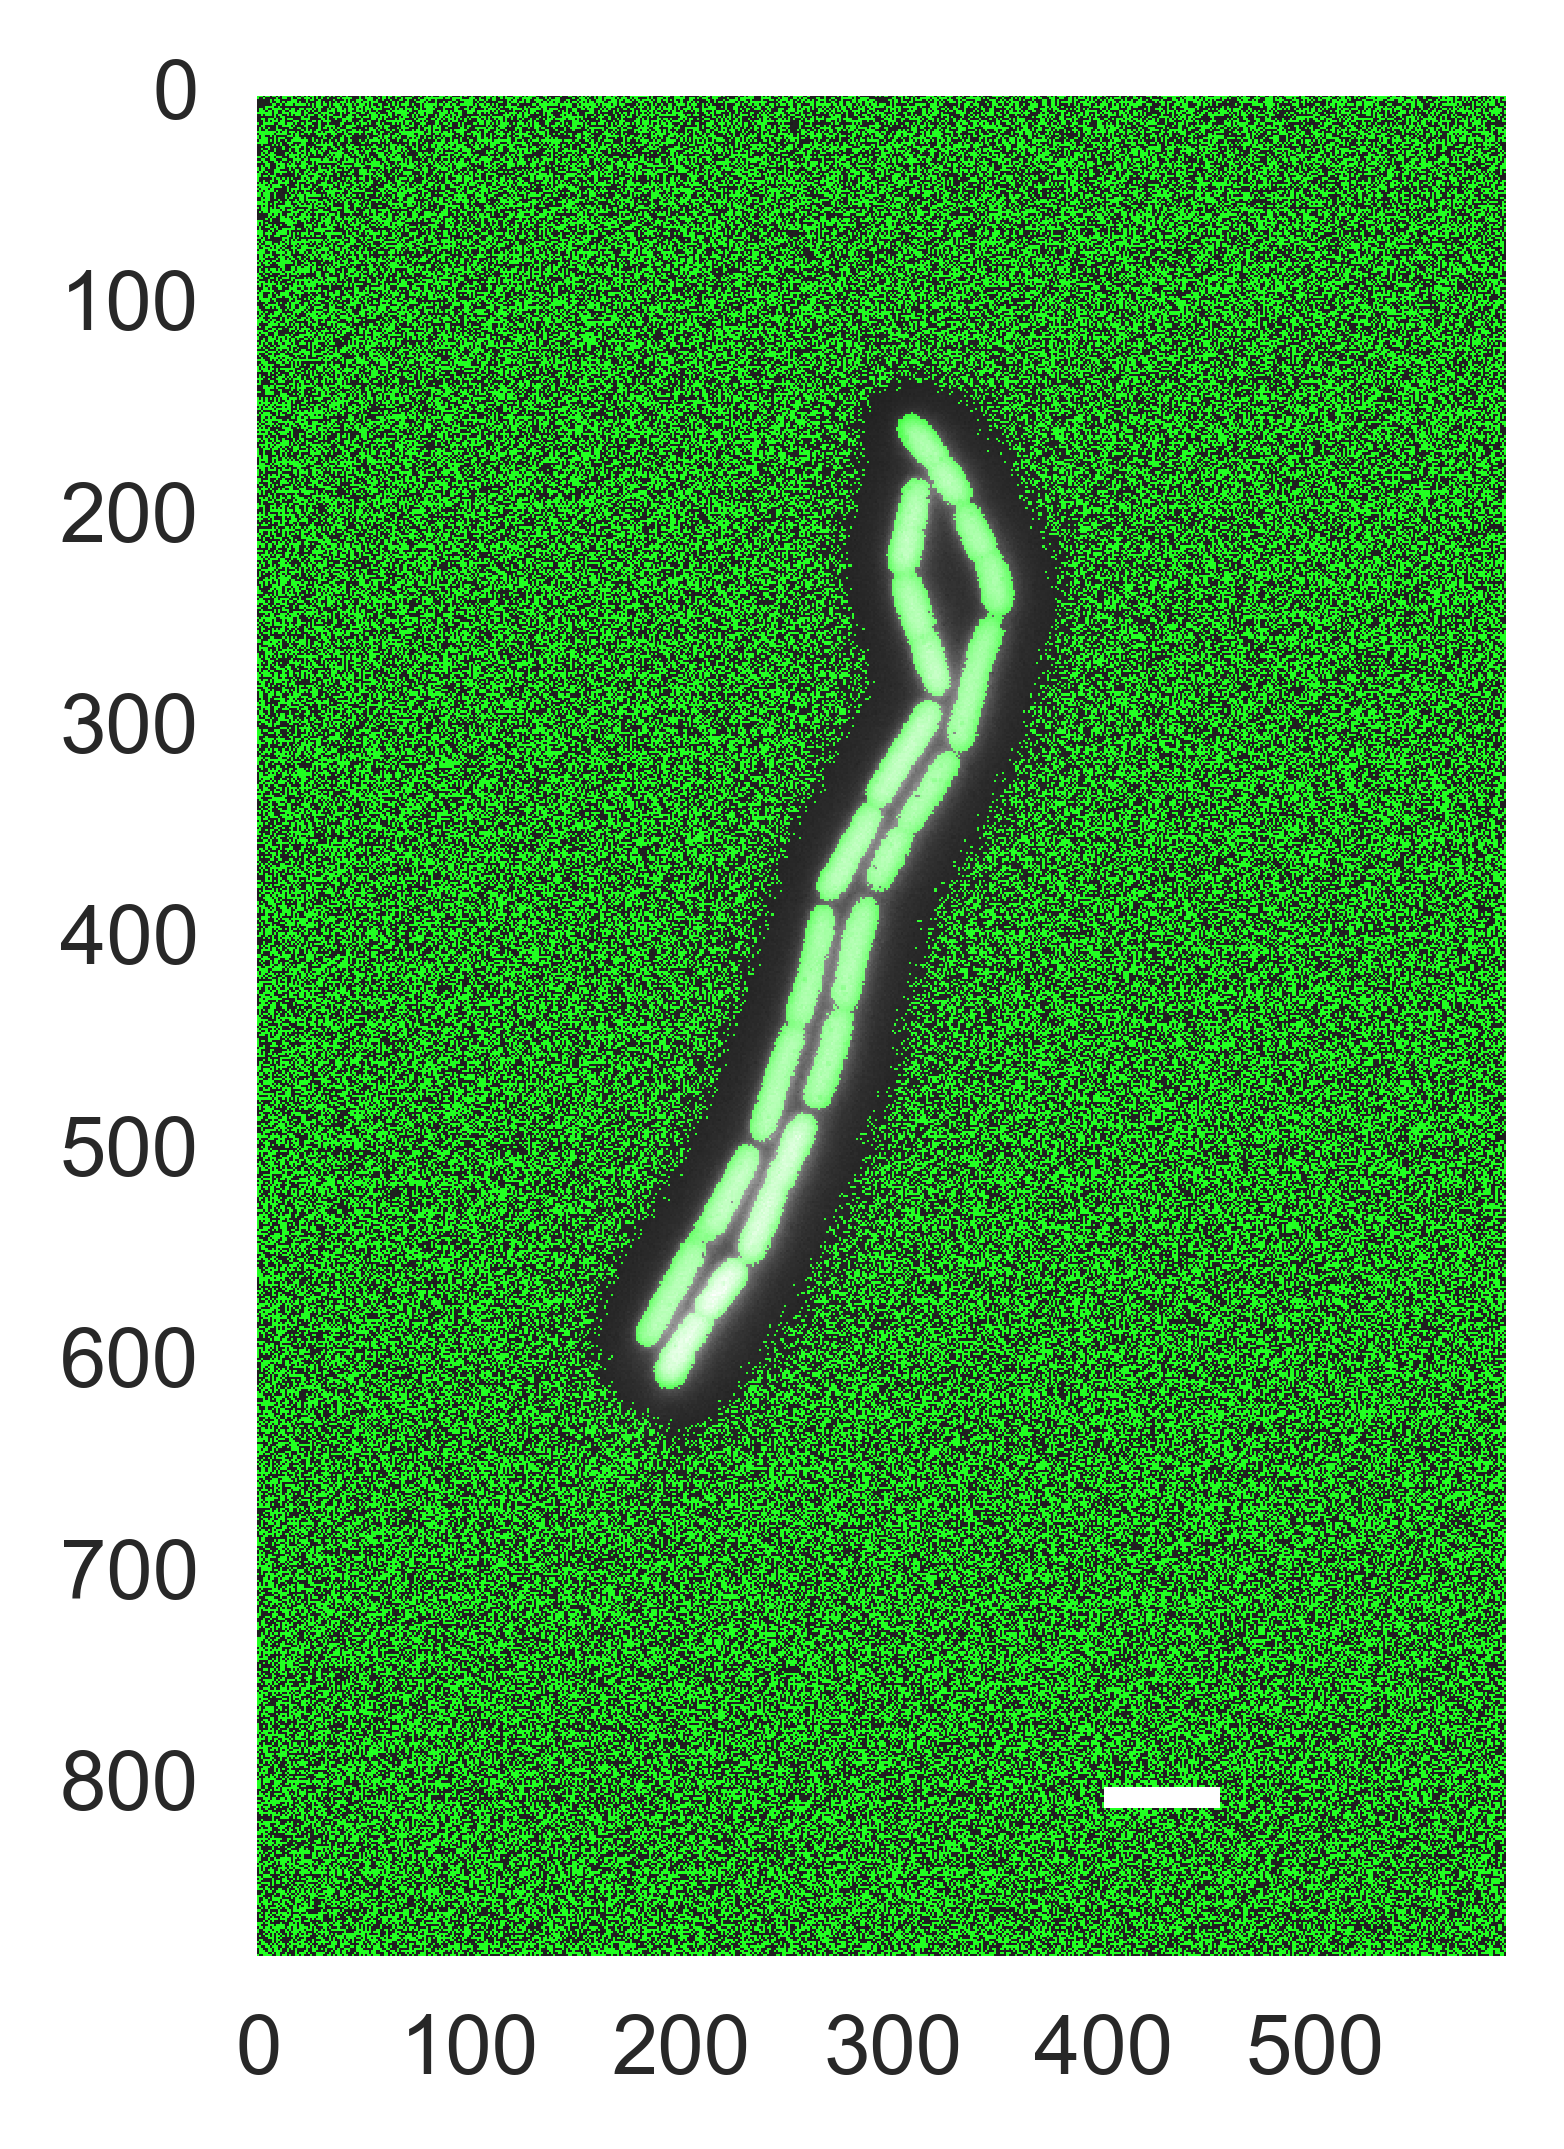

In [22]:
# Initialize list of thresholded images
ims_bw = [None] * len(ims)

# Threshold the images
for i, im in enumerate(ims):
    ims_bw[i] = skimage.filters.threshold_adaptive(im, 51)

# Image to use, and normalize
im = np.copy(ims[40]).astype(float)
im /= im.max()

# Burn scale bar
im[800:810, 400:455] = 1.0

# Build RGB image by stacking grayscale images
im_rgb = np.dstack(3 * [im / im.max()])

# Saturate red channel wherever there are white pixels in thresh image
im_rgb[ims_bw[40], 1] = 1.0

# Show the result
with sns.axes_style('dark'):
    plt.imshow(im_rgb)

Whoa!  It did a great job with the bacteria, but the background got really messed up.  We could include pixels that are unity in both the adaptive and Otsu thresholding to take care of this.  We then use `np.logical_and()` to do an element-by-element `AND` operation on the arrays.

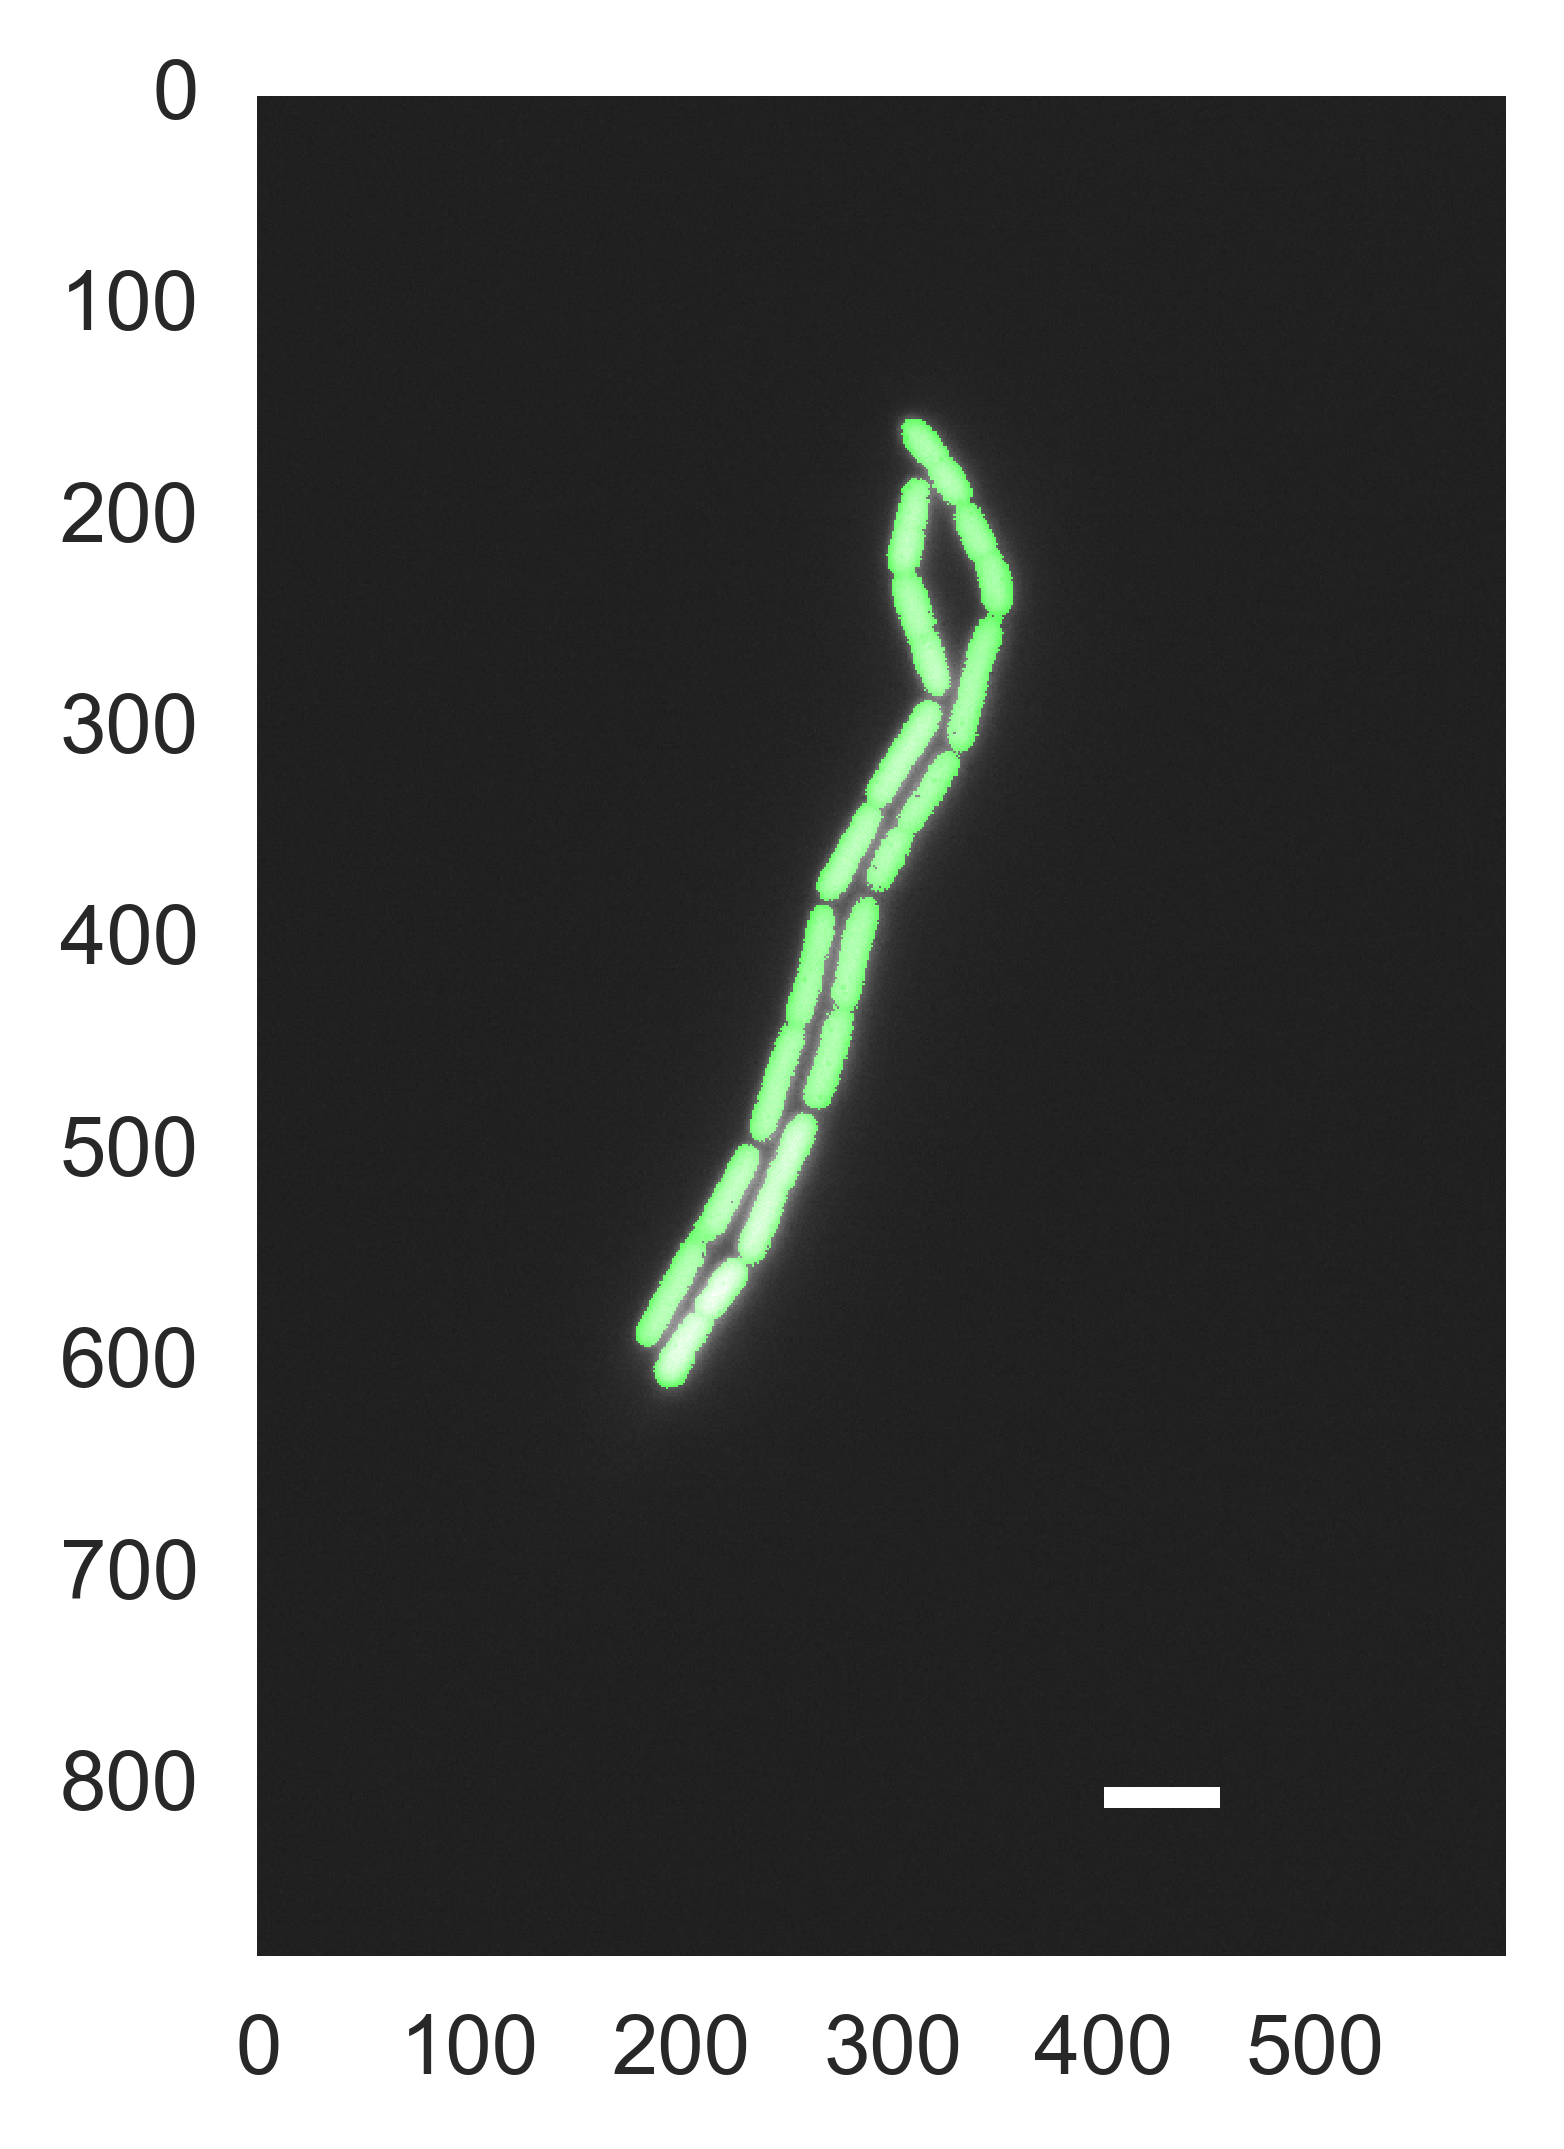

In [23]:
# Initialize list of thresholded images
ims_bw = [None] * len(ims)

# Threshold the images
for i, im in enumerate(ims):
    thresh_otsu = skimage.filters.threshold_otsu(im)
    im_bw = im > thresh_otsu
    ims_bw[i] = np.logical_and(skimage.filters.threshold_adaptive(im, 51), im_bw)

# Image to use, and normalize
im = np.copy(ims[40]).astype(float)
im /= im.max()

# Burn scale bar
im[800:810, 400:455] = 1.0

# Build RGB image by stacking grayscale images
im_rgb = np.dstack(3 * [im / im.max()])

# Saturate red channel wherever there are white pixels in thresh image
im_rgb[ims_bw[40], 1] = 1.0

# Show the result
with sns.axes_style('dark'):
    plt.imshow(im_rgb)

Very nice!

**d)** To plot the growth curve, we can plot the total bacterial area on the $y$-axis, versus time on the $x$-axis.  To get the total area, we need to compute the total number of "bacterial" pixels in a given image, multiplied by the pixel area, which is $(64.5\text{ nm})^2 = 4160.25\text{ nm}^2$.  Also, according to the metadata, we have one frame every 15 minutes.

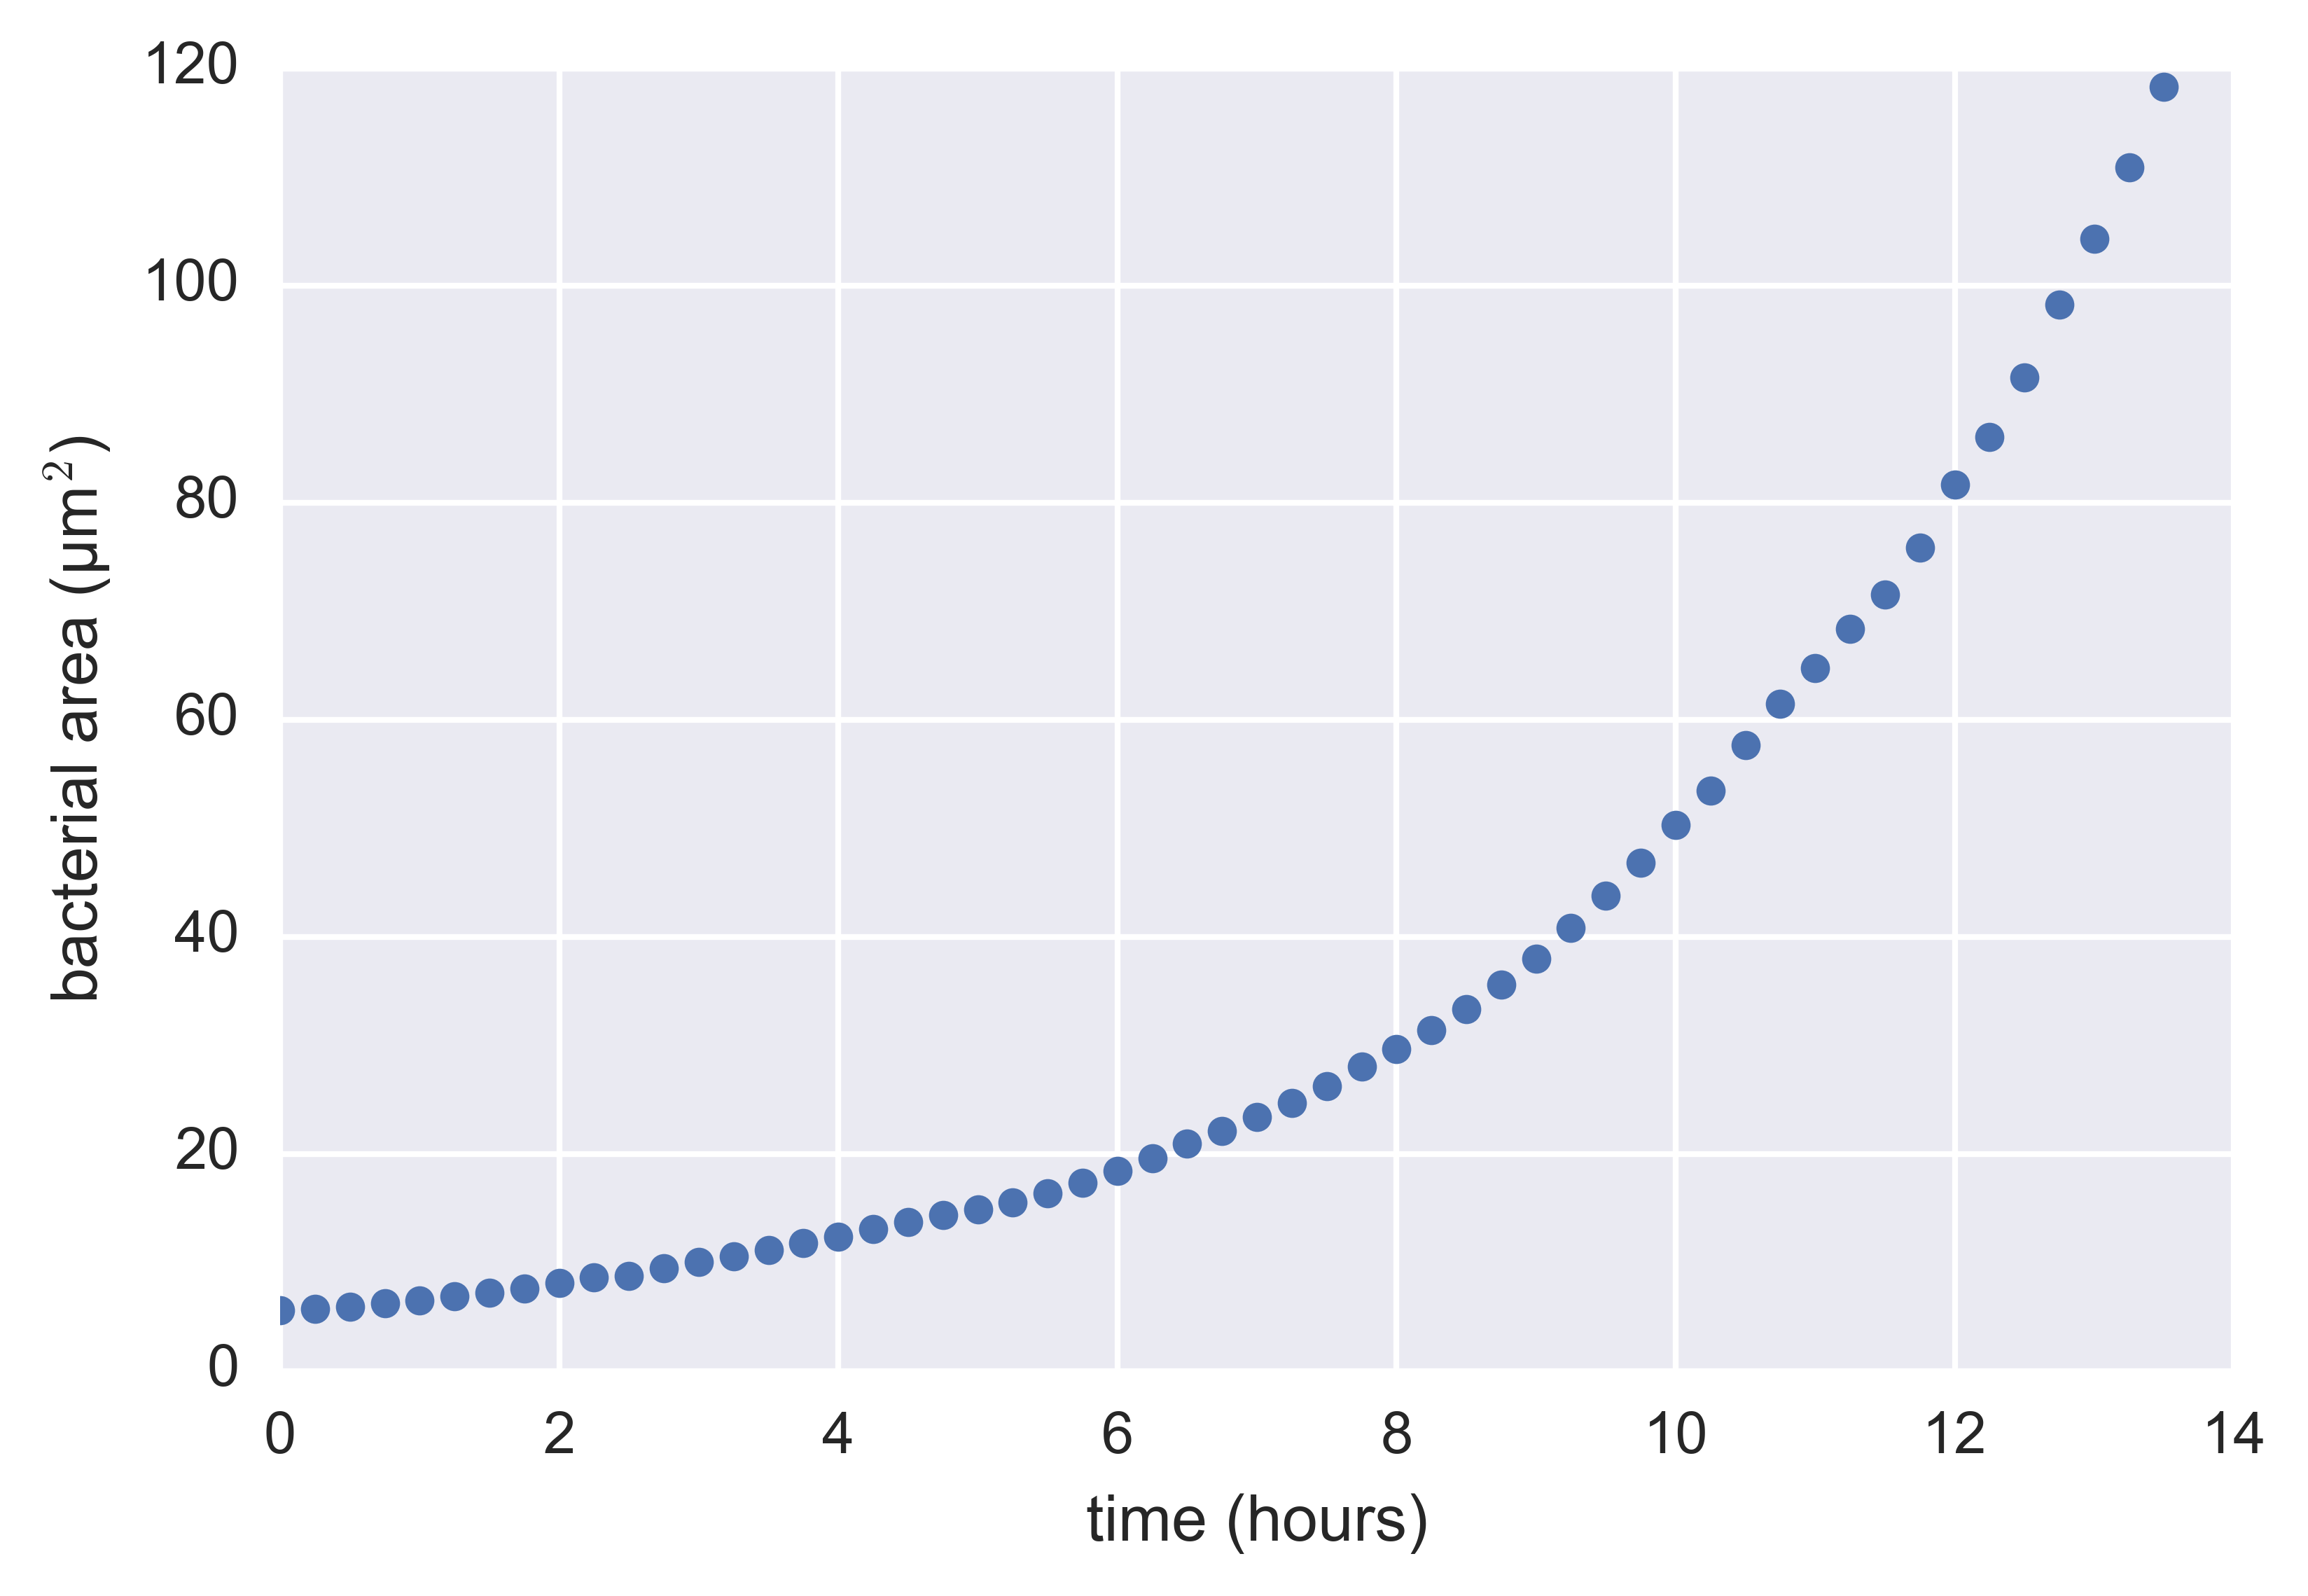

In [24]:
# Compute pixel area
pixel_area = 0.0645**2

# Get total bacterial area
bac_area = np.empty(len(ims_bw))
for i, im_bw in enumerate(ims_bw):
    bac_area[i] = im_bw.sum() * pixel_area
   
# Get time in units of hours
t = 0.25 * np.arange(len(ims_bw))

# Plot the result
plt.plot(t, bac_area, marker='.', linestyle='', markersize=10)
plt.xlabel('time (hours)')
plt.ylabel('bacterial area (µm$^2$)')

**e)** To perform the regression on the growth curve, we assume exponential growth, or

\begin{align}
b(t) = b_0 \mathrm{e}^{t/\tau},
\end{align}

where $\tau$ is the characteristic time for growth.  We *could* just take the logarithm of the data and do a linear regression, but we will perform a nonlinear regression here.


b_0 = 4.34 sq. µm
  τ = 4.09 hours



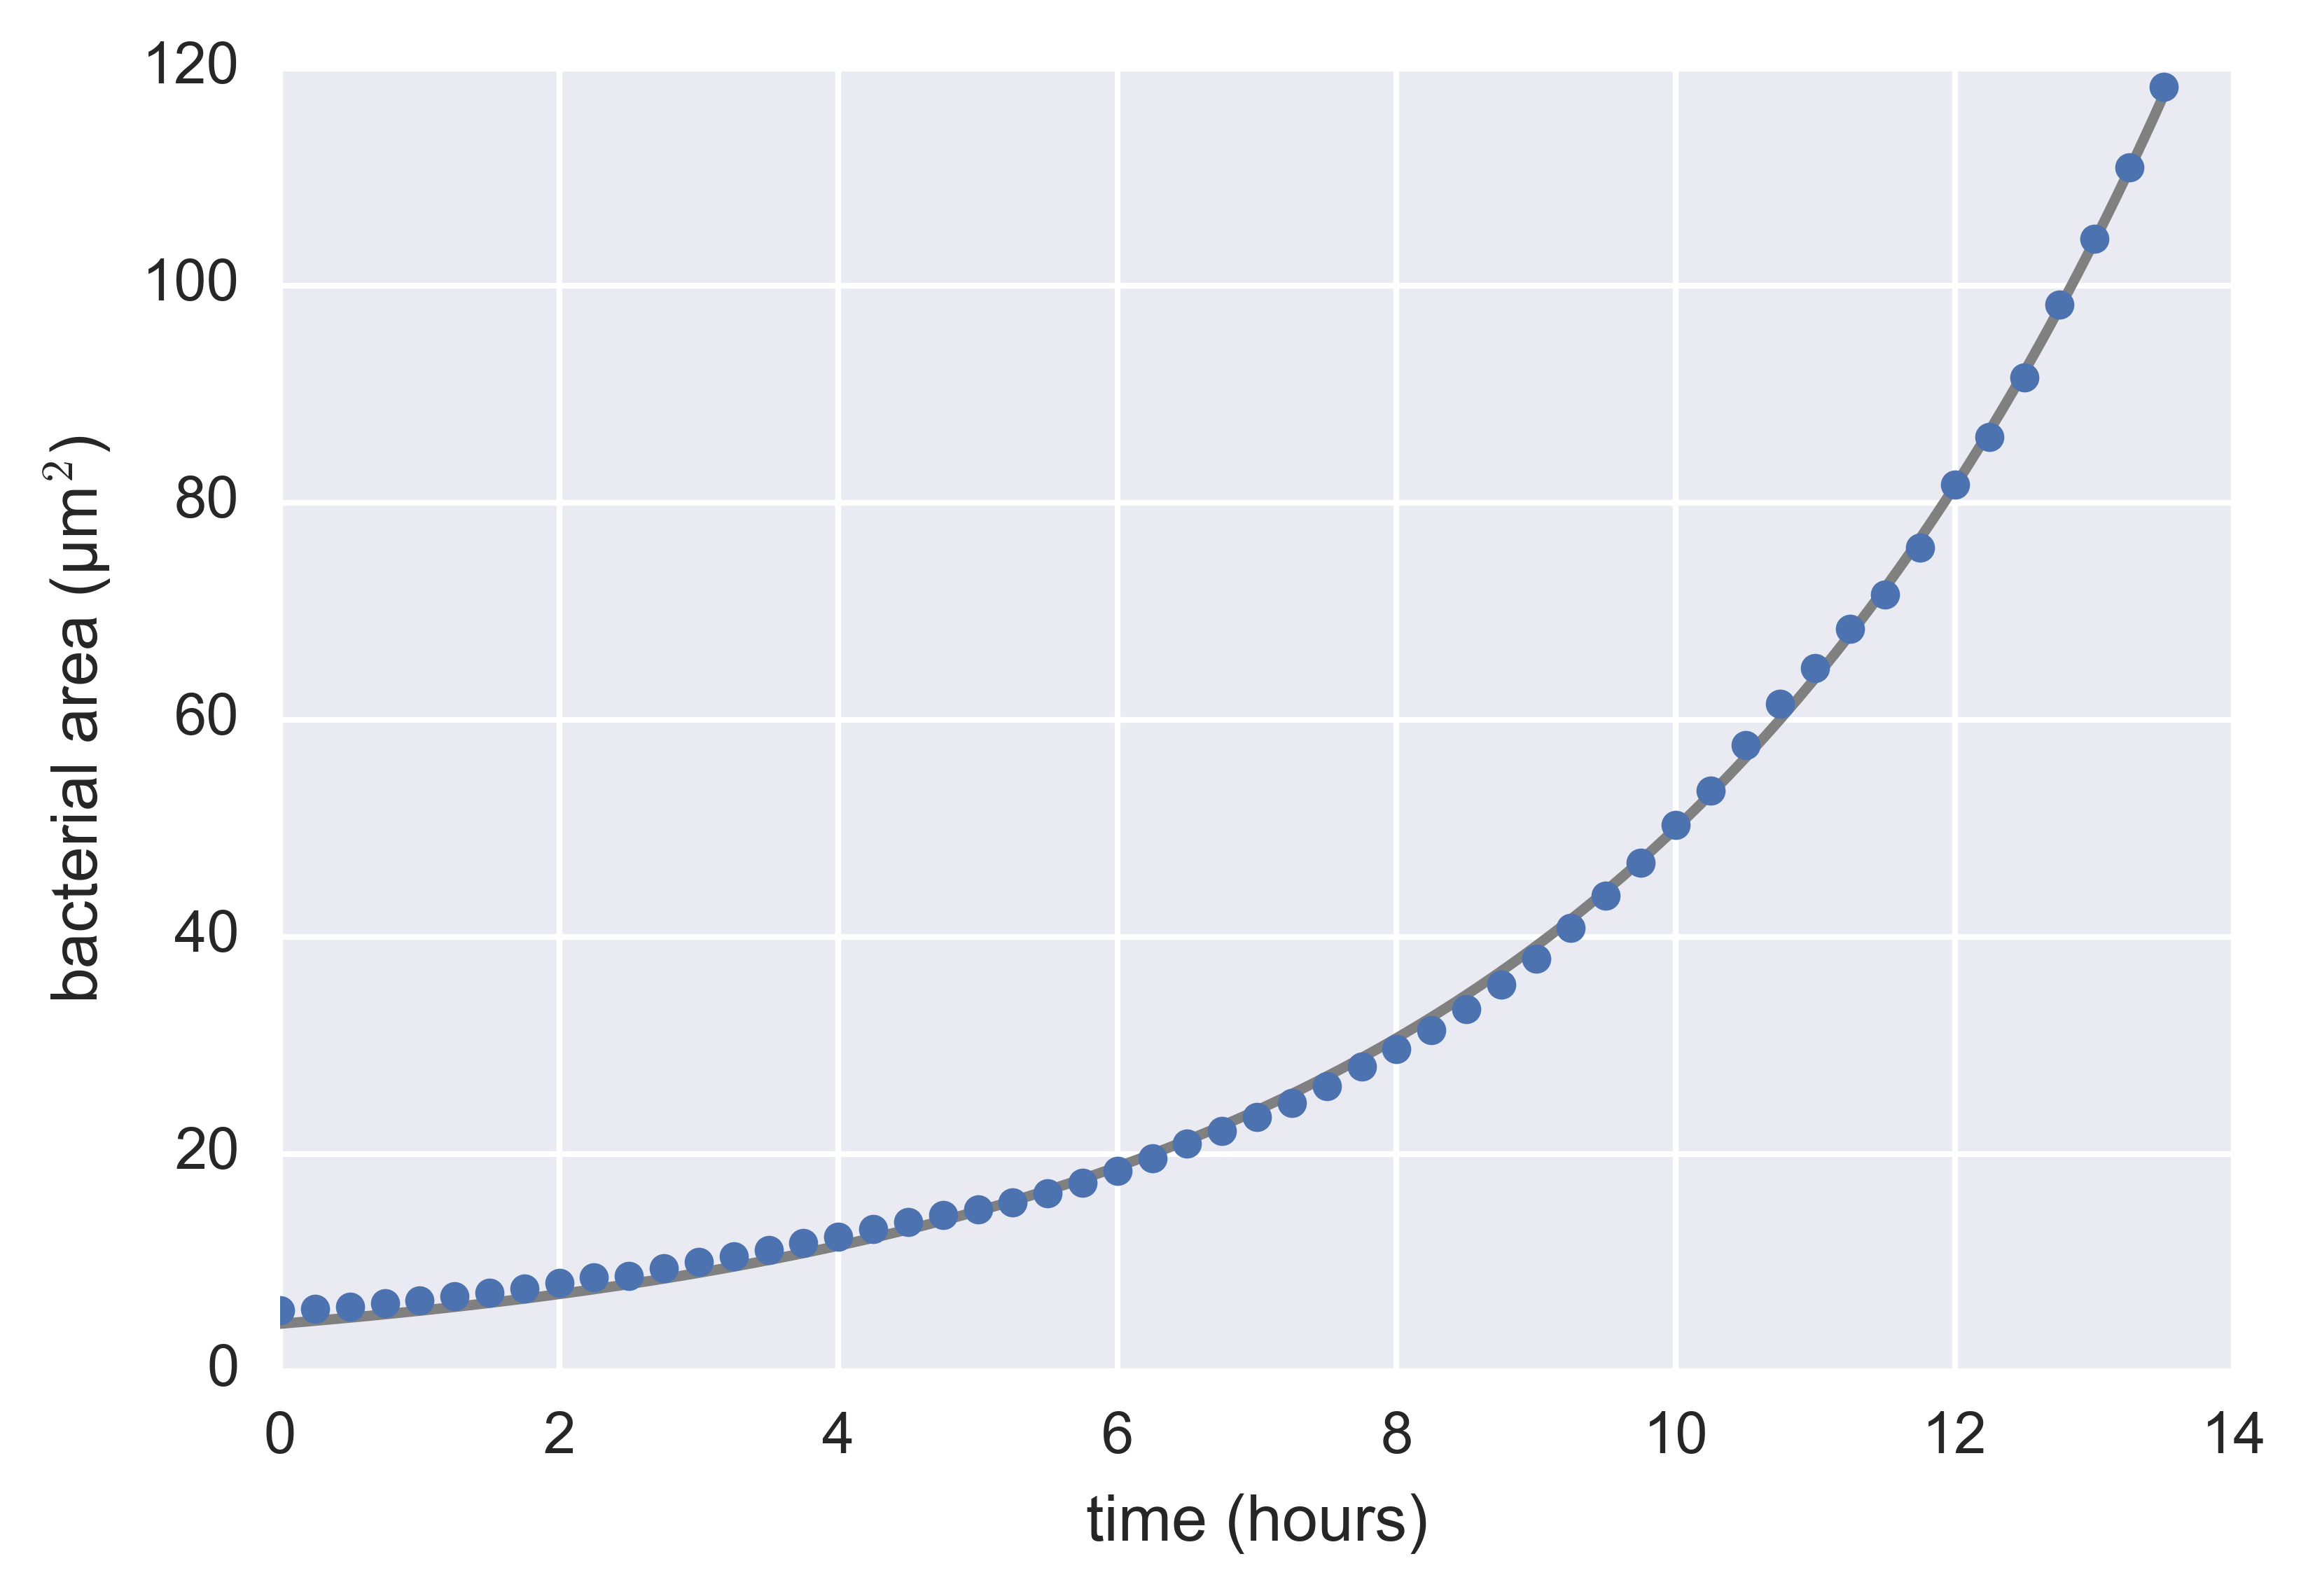

In [27]:
# Define the fit function
def exp_growth(t, log_b_0, log_tau):
    """Exponential growth with log arguments."""
    return np.exp(log_b_0) * np.exp(t / np.exp(log_tau))

# Initial guess
p0 = np.log(np.array([5.0, 12.0]))

# Perform the curve fit
log_p, _ = scipy.optimize.curve_fit(exp_growth, t, bac_area, p0)

# Pull out and print parameters
print("""
b_0 = {0:.2f} sq. µm
  τ = {1:.2f} hours
""".format(*tuple(np.exp(log_p))))

# Generate smooth curve
t_smooth = np.linspace(0, t.max(), 200)
y_smooth = exp_growth(t_smooth, *tuple(log_p))

# Make smooth plot and plot data
plt.plot(t_smooth, y_smooth, marker='None', linestyle='-', color='gray')
plt.plot(t, bac_area, marker='.', linestyle='', markersize=10)
plt.xlabel('time (hours)')
plt.ylabel('bacterial area (µm$^2$)')

There is some systematic error, it appears, with the data being consistently above the curve at short times and then below for intermediate times.  This could be due to thresholding, or due to small changes in conditions over time.

## Exercise 5.2: Filter, extract, rinse, repeat

So far we have seen that in a single (very clean) image, we can get somewhere around 20 - 30 well-separated cells in a single 100$\times$ magnification phase contrast image. However, if you wish to report a mean fluorescence intensity for a single strain, you would certainly want more cells to have a good degree of confidence. Using the principles you learned above, your job will be to report a mean fluorescence value for the HG105 *E. coli* strain using **all** of the images located in `data/HG105_images/`. To do this, you should do the following:

>1. Get a list of all of the image files in `data/HG105_images/`.
2. Separate them by phase contrast (for segmentation) and FITC (for measurement). 
3. Iterate through each image file and perform segmentation and fluorescence intensity extraction for each cell. These values should be stored in a NumPy array or Pandas `DataFrame`.  
4. Plot a histogram of all extracted fluorescence intensities and report a mean and standard deviation as well as the number of cells you successfully measured. 
5. Obtain 95% bootstrap confidence intervals for the mean and standard deviation of the fluorescence intensities.

As a reminder, the interpixel distance of these images is 0.0636 µm per pixel.

###  Exercise 5.2: solution

To begin, we can copy our cell segmentation functions from our [image processing practice]('l40_image_processing_practice_solution.html) session.

In [3]:
def cell_segmenter(im, thresh='otsu', radius=20.0, image_mode='phase',
                   area_bounds=(0,1e7), ecc_bounds=(0, 1)):
    """
    This function segments a given image via thresholding and returns a labeled 
    segmentation mask.
    
    Parameters
    ----------
    im : 2d-array
        Image to be segmented. This may be of either float or
        integer data type.
    thresh : int, float, or 'otsu'
        Value used during thresholding operation. This can either be a value 
        (`int` or `float`) or 'otsu'. If 'otsu', the threshold value will be 
        determined automatically using Otsu's thresholding method.
    radius : float
        Radius for gaussian blur for background subtraction. Default 
        value is 20.
    image_mode : 'phase' or 'fluorescence'
        Mode of microscopy used to capture the image. If 'phase', objects
        with intensity values *lower* than the provided threshold will be
        selected. If `fluorescence`, values *greater* than the provided 
        threshold will be selected. Default value is 'phase'.
    area_bounds : tuple of ints.
        Range of areas of acceptable objects. This should be provided in units 
        of square pixels.
    ecc_bounds : tuple of floats
        Range of eccentricity values of acceptable objects. These values should
        range between 0.0 and 1.0.
        
    Returns
    -------
    im_labeled : 2d-array, int
        Labeled segmentation mask.
    """
     
    # Apply a median filter to remove hot pixels.
    med_selem = skimage.morphology.square(3)
    im_filt = skimage.filters.median(im, selem=med_selem)
   
    # Perform gaussian subtraction
    im_sub = bg_subtract(im_filt, radius)
    
    # Determine the thresholding method.
    if thresh is 'otsu':
        thresh = skimage.filters.threshold_otsu(im_sub)

    # Determine the image mode and apply threshold.
    if image_mode is 'phase':
        im_thresh = im_sub < thresh
    elif image_mode is 'fluorescence':
        im_thresh = im_sub > thresh
    else:
        raise ValueError("image mode not recognized. Must be 'phase' "
                          + " or 'fluorescence'")
       
    # Label the objects.
    im_label = skimage.measure.label(im_thresh)

    # Apply the area and eccentricity bounds. 
    im_filt = area_ecc_filter(im_label, area_bounds, ecc_bounds)
    
    # Remove objects touching the border.
    im_border = skimage.segmentation.clear_border(im_filt, buffer_size=5)
    
    # Relabel the image.
    im_border = im_border > 0 
    im_label = skimage.measure.label(im_border)
    
    return im_label


def bg_subtract(im, radius):
    """
    Subtracts a gaussian blurred image from itself smoothing uneven 
    illumination.
    
    Parameters
    ----------
    im : 2d-array
        Image to be subtracted
    radius : int or float
        Radius of gaussian blur
    
    Returns
    -------
    im_sub : 2d-array, float
        Background subtracted image.
    """
    
    # Apply the gaussian filter.
    im_filt = skimage.filters.gaussian(im, radius)
    
    # Ensure the original image is a float
    if np.max(im) > 1.0:
        im = skimage.img_as_float(im)
    
    im_sub = im - im_filt
    
    return  im_sub


def area_ecc_filter(im, area_bounds, ecc_bounds):
    """
    Filters objects in an image based on their areas.
    
    Parameters
    ----------
    im : 2d-array, int
        Labeled segmentation mask to be filtered. 
    area_bounds : tuple of ints
        Range of areas in which acceptable objects exist. This should be 
        provided in units of square pixels.
    ecc_bounds : tuple of floats 
        Range of eccentricities in which acceptable objects exist.
        This should be provided on the range of 0 to 1.0.
        
    Returns
    -------
    im_relab : 2d-array, int
        The relabeled, filtered image.
    """
 
    # Extract the region props of the objects. 
    props = skimage.measure.regionprops(im)
    
    # Extract the areas and labels.
    areas = np.array([prop.area for prop in props])
    eccs = np.array([prop.eccentricity for prop in props])
    labels = np.array([prop.label for prop in props])

    # Make an empty image to add the approved cells.
    im_approved = np.zeros_like(im)
    
    # Threshold the objects based on area and eccentricity
    for i, _ in enumerate(areas):
        if areas[i] > area_bounds[0] and areas[i] < area_bounds[1]\
            and eccs[i] > ecc_bounds[0] and eccs[i] < ecc_bounds[1]:
                im_approved += im==labels[i]
   
    # Relabel the image.
    im_filt = skimage.measure.label(im_approved > 0)
    return im_filt

Now we need to figure out some way in which we can iterate over all of our images in `data/HG105_images`. We have a few options here. First, and this is the worst solution, we could type out the name of each individual file and load them individually. The other option (the right option) is to make our computer get the list of all files in a single (or a few) lines of code. Let's start with using one of the standard python modules `os`. `os` has a method which will allow us to list all of the files in a provided directory. 

In [4]:
# Define the directory where the images live. 
data_dir = 'data/HG105_images/'

# List the data files using os. 
files = os.listdir(data_dir)
files

['noLac_FITC_0000.tif',
 'noLac_FITC_0001.tif',
 'noLac_FITC_0002.tif',
 'noLac_FITC_0003.tif',
 'noLac_FITC_0004.tif',
 'noLac_FITC_0005.tif',
 'noLac_FITC_0006.tif',
 'noLac_FITC_0007.tif',
 'noLac_FITC_0008.tif',
 'noLac_phase_0000.tif',
 'noLac_phase_0001.tif',
 'noLac_phase_0002.tif',
 'noLac_phase_0003.tif',
 'noLac_phase_0004.tif',
 'noLac_phase_0005.tif',
 'noLac_phase_0006.tif',
 'noLac_phase_0007.tif',
 'noLac_phase_0008.tif']

Cool! So `os.list_dir(directory)` returns a list that contains all of the file names in our defined `data_dir`. Note, however that they don't separate the images based on phase or fluorescence. We can separate these into two different lists using a pretty simple for loop. 

In [5]:
# Make empty lists for the phase and fluorescence images. 
phase_ims, fluo_ims = [], []

# Loop through all of the file names in files and separate them appropriately. 
for _, f in enumerate(files):
    if 'phase' in f.lower():
        phase_ims.append(f)
    if 'fitc' in f.lower():
        fluo_ims.append(f)

#To be safe, sort both so they ar ein the same order. 
phase_ims.sort()
fluo_ims.sort()

#Take a look!
print(phase_ims, fluo_ims)

['noLac_phase_0000.tif', 'noLac_phase_0001.tif', 'noLac_phase_0002.tif', 'noLac_phase_0003.tif', 'noLac_phase_0004.tif', 'noLac_phase_0005.tif', 'noLac_phase_0006.tif', 'noLac_phase_0007.tif', 'noLac_phase_0008.tif'] ['noLac_FITC_0000.tif', 'noLac_FITC_0001.tif', 'noLac_FITC_0002.tif', 'noLac_FITC_0003.tif', 'noLac_FITC_0004.tif', 'noLac_FITC_0005.tif', 'noLac_FITC_0006.tif', 'noLac_FITC_0007.tif', 'noLac_FITC_0008.tif']


It looks like we've successfully separated the phase and fluorescence image names and they even seem to be in order (thanks to our `sort` method). While this was pretty easy to do, there is an even easier way using the magic that is `glob`. `glob` has a bunch of methods for obtaining filenames from directories. The most useful method of `glob` is `glob` which will return a list of paths that match a given pattern. Let's see how well it works for our needs. 

In [6]:
# Glob the phase and fluo globs. 
phase_glob = glob.glob(data_dir + '*phase*.tif')
fluo_glob = glob.glob(data_dir + '*FITC*.tif')

# Take a look.
print(phase_glob, fluo_glob)

['data/HG105_images/noLac_phase_0000.tif', 'data/HG105_images/noLac_phase_0001.tif', 'data/HG105_images/noLac_phase_0002.tif', 'data/HG105_images/noLac_phase_0003.tif', 'data/HG105_images/noLac_phase_0004.tif', 'data/HG105_images/noLac_phase_0005.tif', 'data/HG105_images/noLac_phase_0006.tif', 'data/HG105_images/noLac_phase_0007.tif', 'data/HG105_images/noLac_phase_0008.tif'] ['data/HG105_images/noLac_FITC_0000.tif', 'data/HG105_images/noLac_FITC_0001.tif', 'data/HG105_images/noLac_FITC_0002.tif', 'data/HG105_images/noLac_FITC_0003.tif', 'data/HG105_images/noLac_FITC_0004.tif', 'data/HG105_images/noLac_FITC_0005.tif', 'data/HG105_images/noLac_FITC_0006.tif', 'data/HG105_images/noLac_FITC_0007.tif', 'data/HG105_images/noLac_FITC_0008.tif']


Well, that was easy. We used the wildcard character (`*`) to find all files that had the pattern `anything` then the strings `phase` or `FITC` followed by `anything` so long that it had a `.tif` extension. The output is a little bit different as well in that it not only returned the name of the file in the specified `data_dir`, but it gave us the entire relative path. This is an important distinction and is actually one of the reasons I frequently use `glob.glob`.

Now that we have a list of files, we should iterate over each phase image, perform the segmentation, then extract the mean pixel intensities of each object and store them in a list. 

In [7]:
# Instantiate an empty list for the mean pixel intensity of each cell.
mean_ints = []

# Do the same for the areas.
areas = []

# Define our area and eccentricity bounds for the segmentation function.
ip_dist = 0.0636  # in units of µm per pixel
area_bounds = (0.5/ip_dist**2, 4/ip_dist**2)
ecc_bounds = (0.8, 1.0)

# Loop through all images.
for p, f in zip(phase_glob, fluo_glob):
    # Load the phase image.
    phase_im = skimage.io.imread(p)
    
    # Perform the segmentation.
    phase_seg = cell_segmenter(phase_im, image_mode='phase', 
                               area_bounds=area_bounds, ecc_bounds=ecc_bounds)
    
    # Load the fluorescence image. 
    fluo_im = skimage.io.imread(f)
    
    # Compute the region properties.
    props = skimage.measure.regionprops(phase_seg, intensity_image=fluo_im)
    
    # Add them to our storage lists. 
    for prop in props:
        mean_ints.append(prop.mean_intensity)
        areas.append(prop.area * ip_dist**2)
        
    
# Convert the lists to numpy arrays for simplicity. 
mean_ints = np.array(mean_ints)
areas = np.array(areas)

/Users/Justin/anaconda/lib/python3.5/site-packages/skimage/filters/rank/generic.py:68: UserWarning: Bitdepth of 11 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


So, in just a few seconds, were were able to do what would take hours (if not a full day) to do in imageJ by clicking. To make sure things are working as expected, let's take a look at the last segmentation mask generated. 

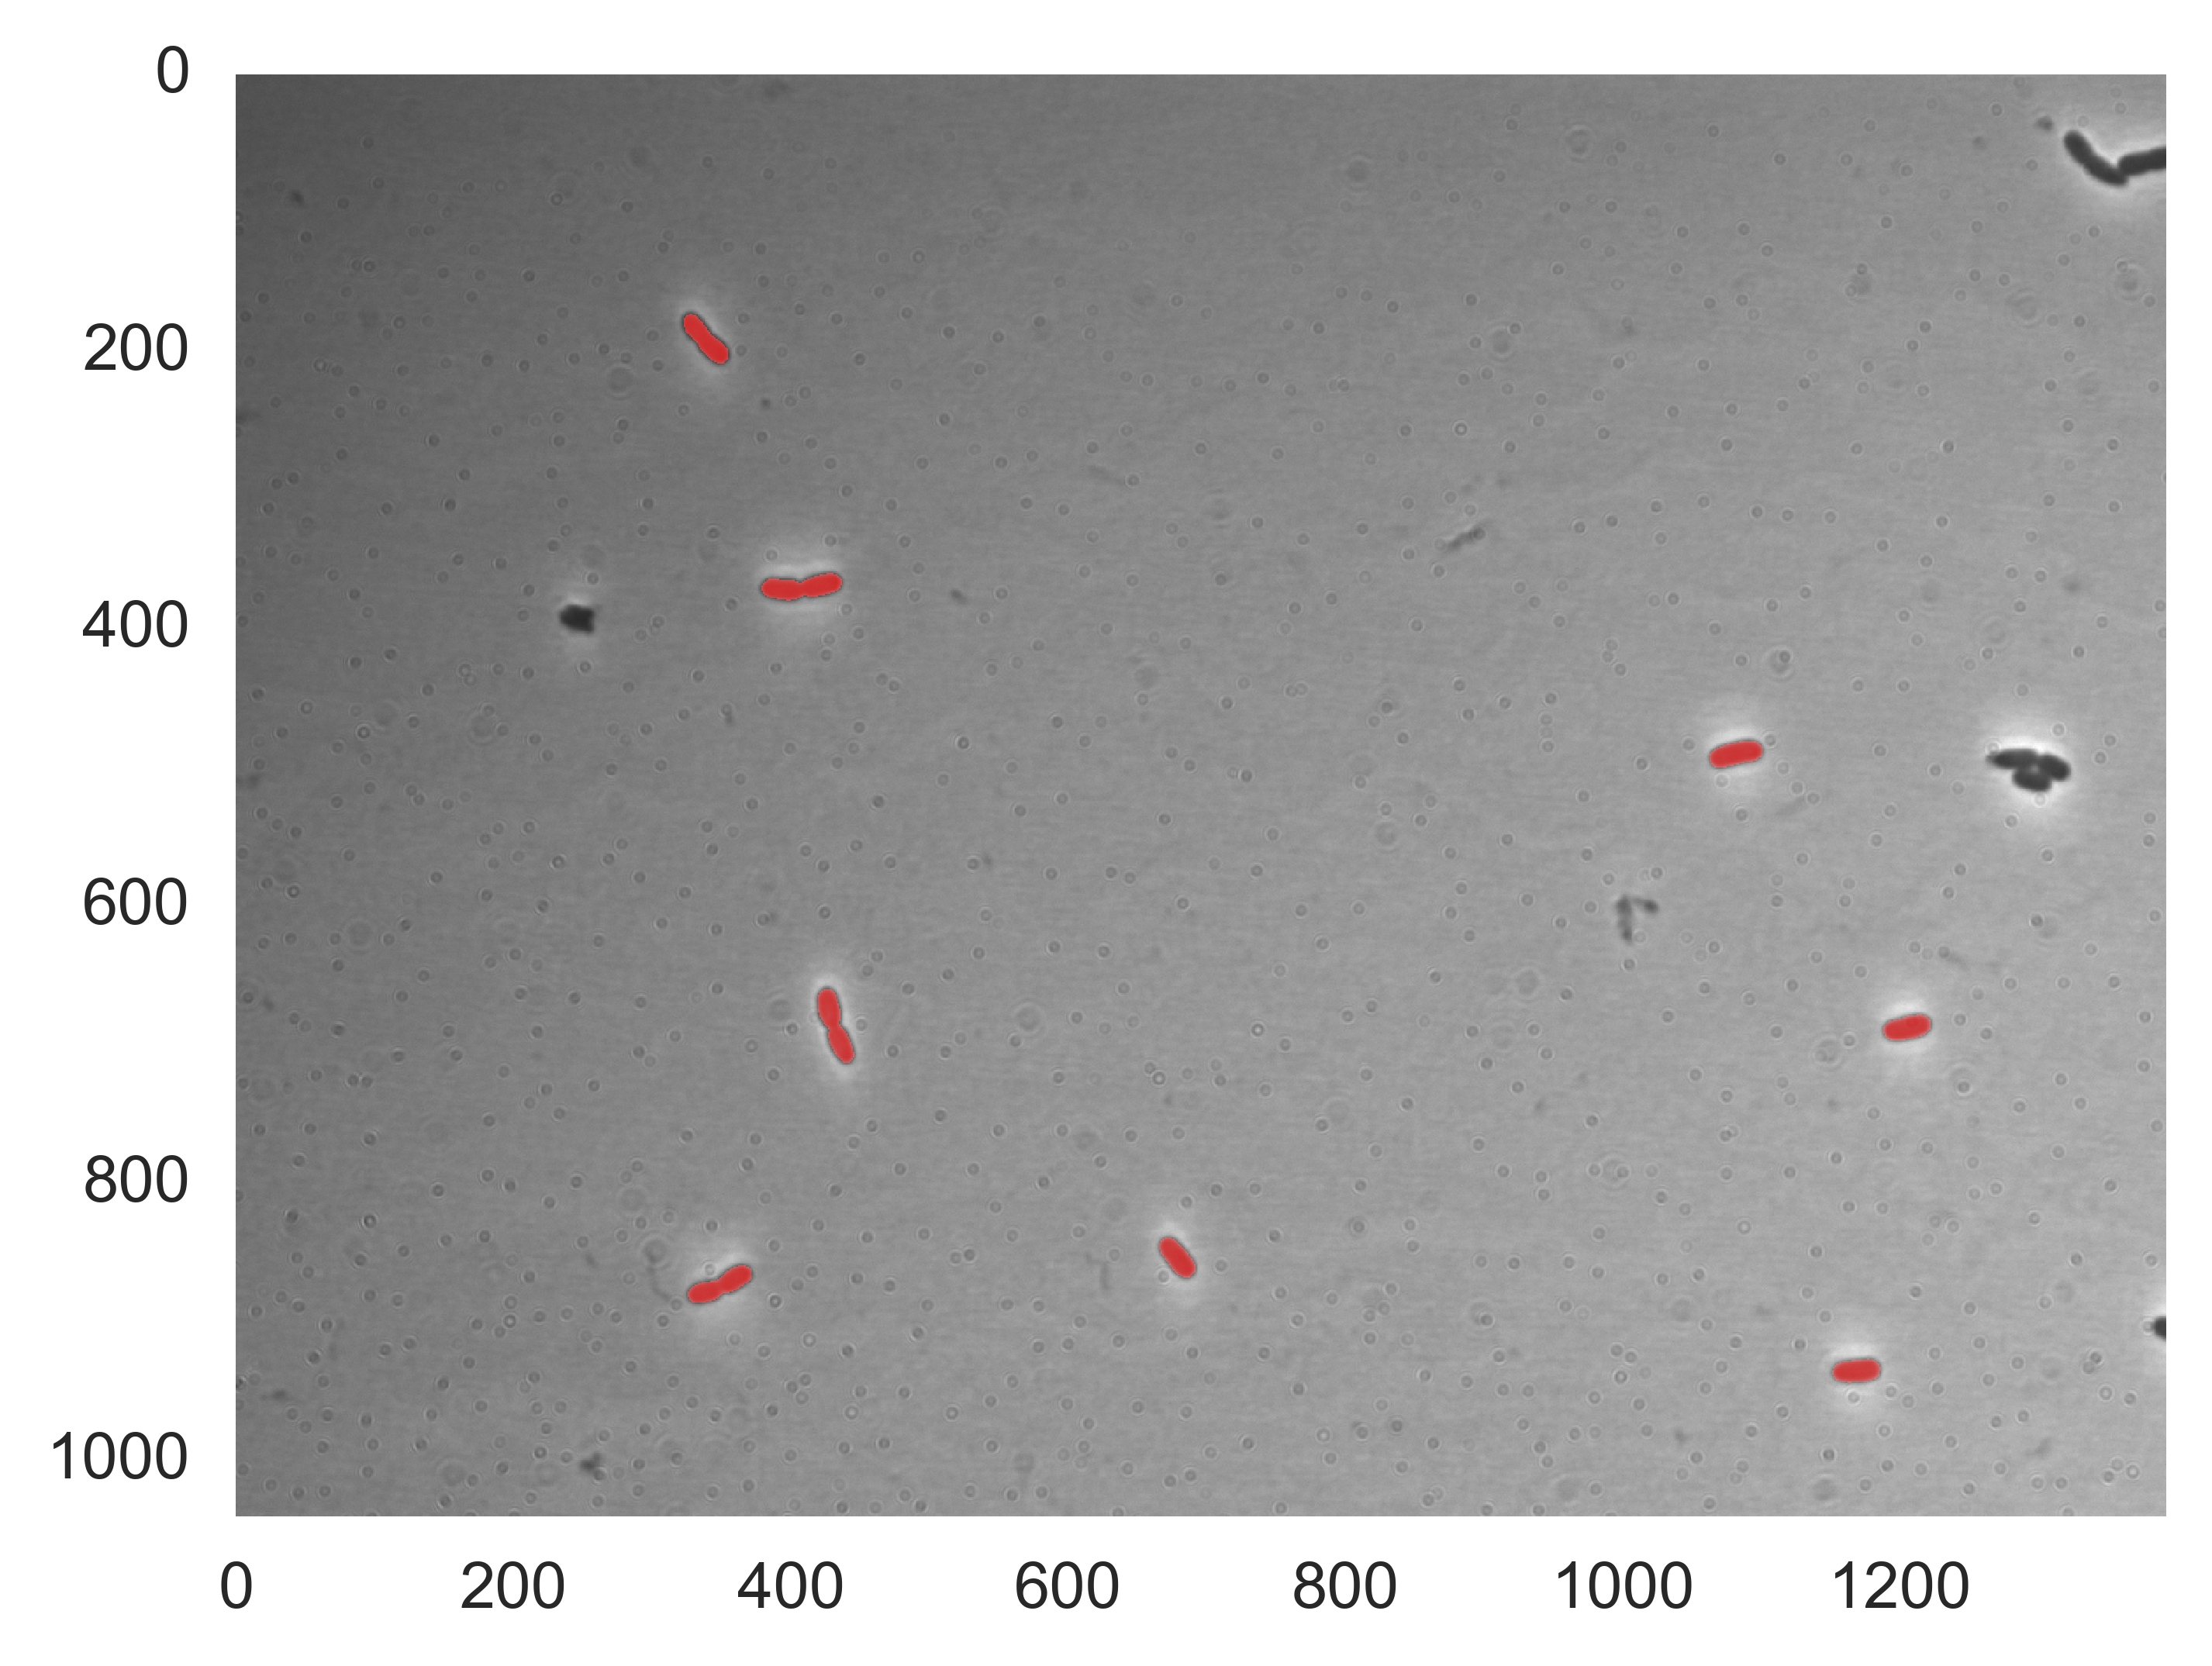

In [8]:
# Convert the phase image to a float and make a copy
phase_float = phase_im / phase_im.max()
phase_float_copy = np.copy(phase_float)

# Mark where the segmentation mask is True on the phase image. 
phase_float_copy[phase_seg > 0] = 0.8

# Color the segmented cells in red. 
merge = np.dstack((phase_float_copy, phase_float, phase_float))

# Let's take a look!
with sns.axes_style('dark'):
    plt.imshow(merge)
    

That looks pretty great to me, let's see how many cells we were actually able to measure. 

In [9]:
# Print the total number of cells. 
print("Segmented and analyzed {num} cells!".format(num=len(mean_ints)))

Segmented and analyzed 92 cells!


Analyzing 92 cells in only 8 images in about 8 seconds is actually pretty good! That's certainly enough to do some serious boot strapping. Let's look at the ECDFs of the mean intensities and the areas. 

In [10]:
# Define the ECDF function. 
def ecdf(data):
    """Compute x, y values for an empirical distribution function."""
    x = np.sort(data)
    y = np.arange(1, len(data)+1) / len(data)
    return x, y

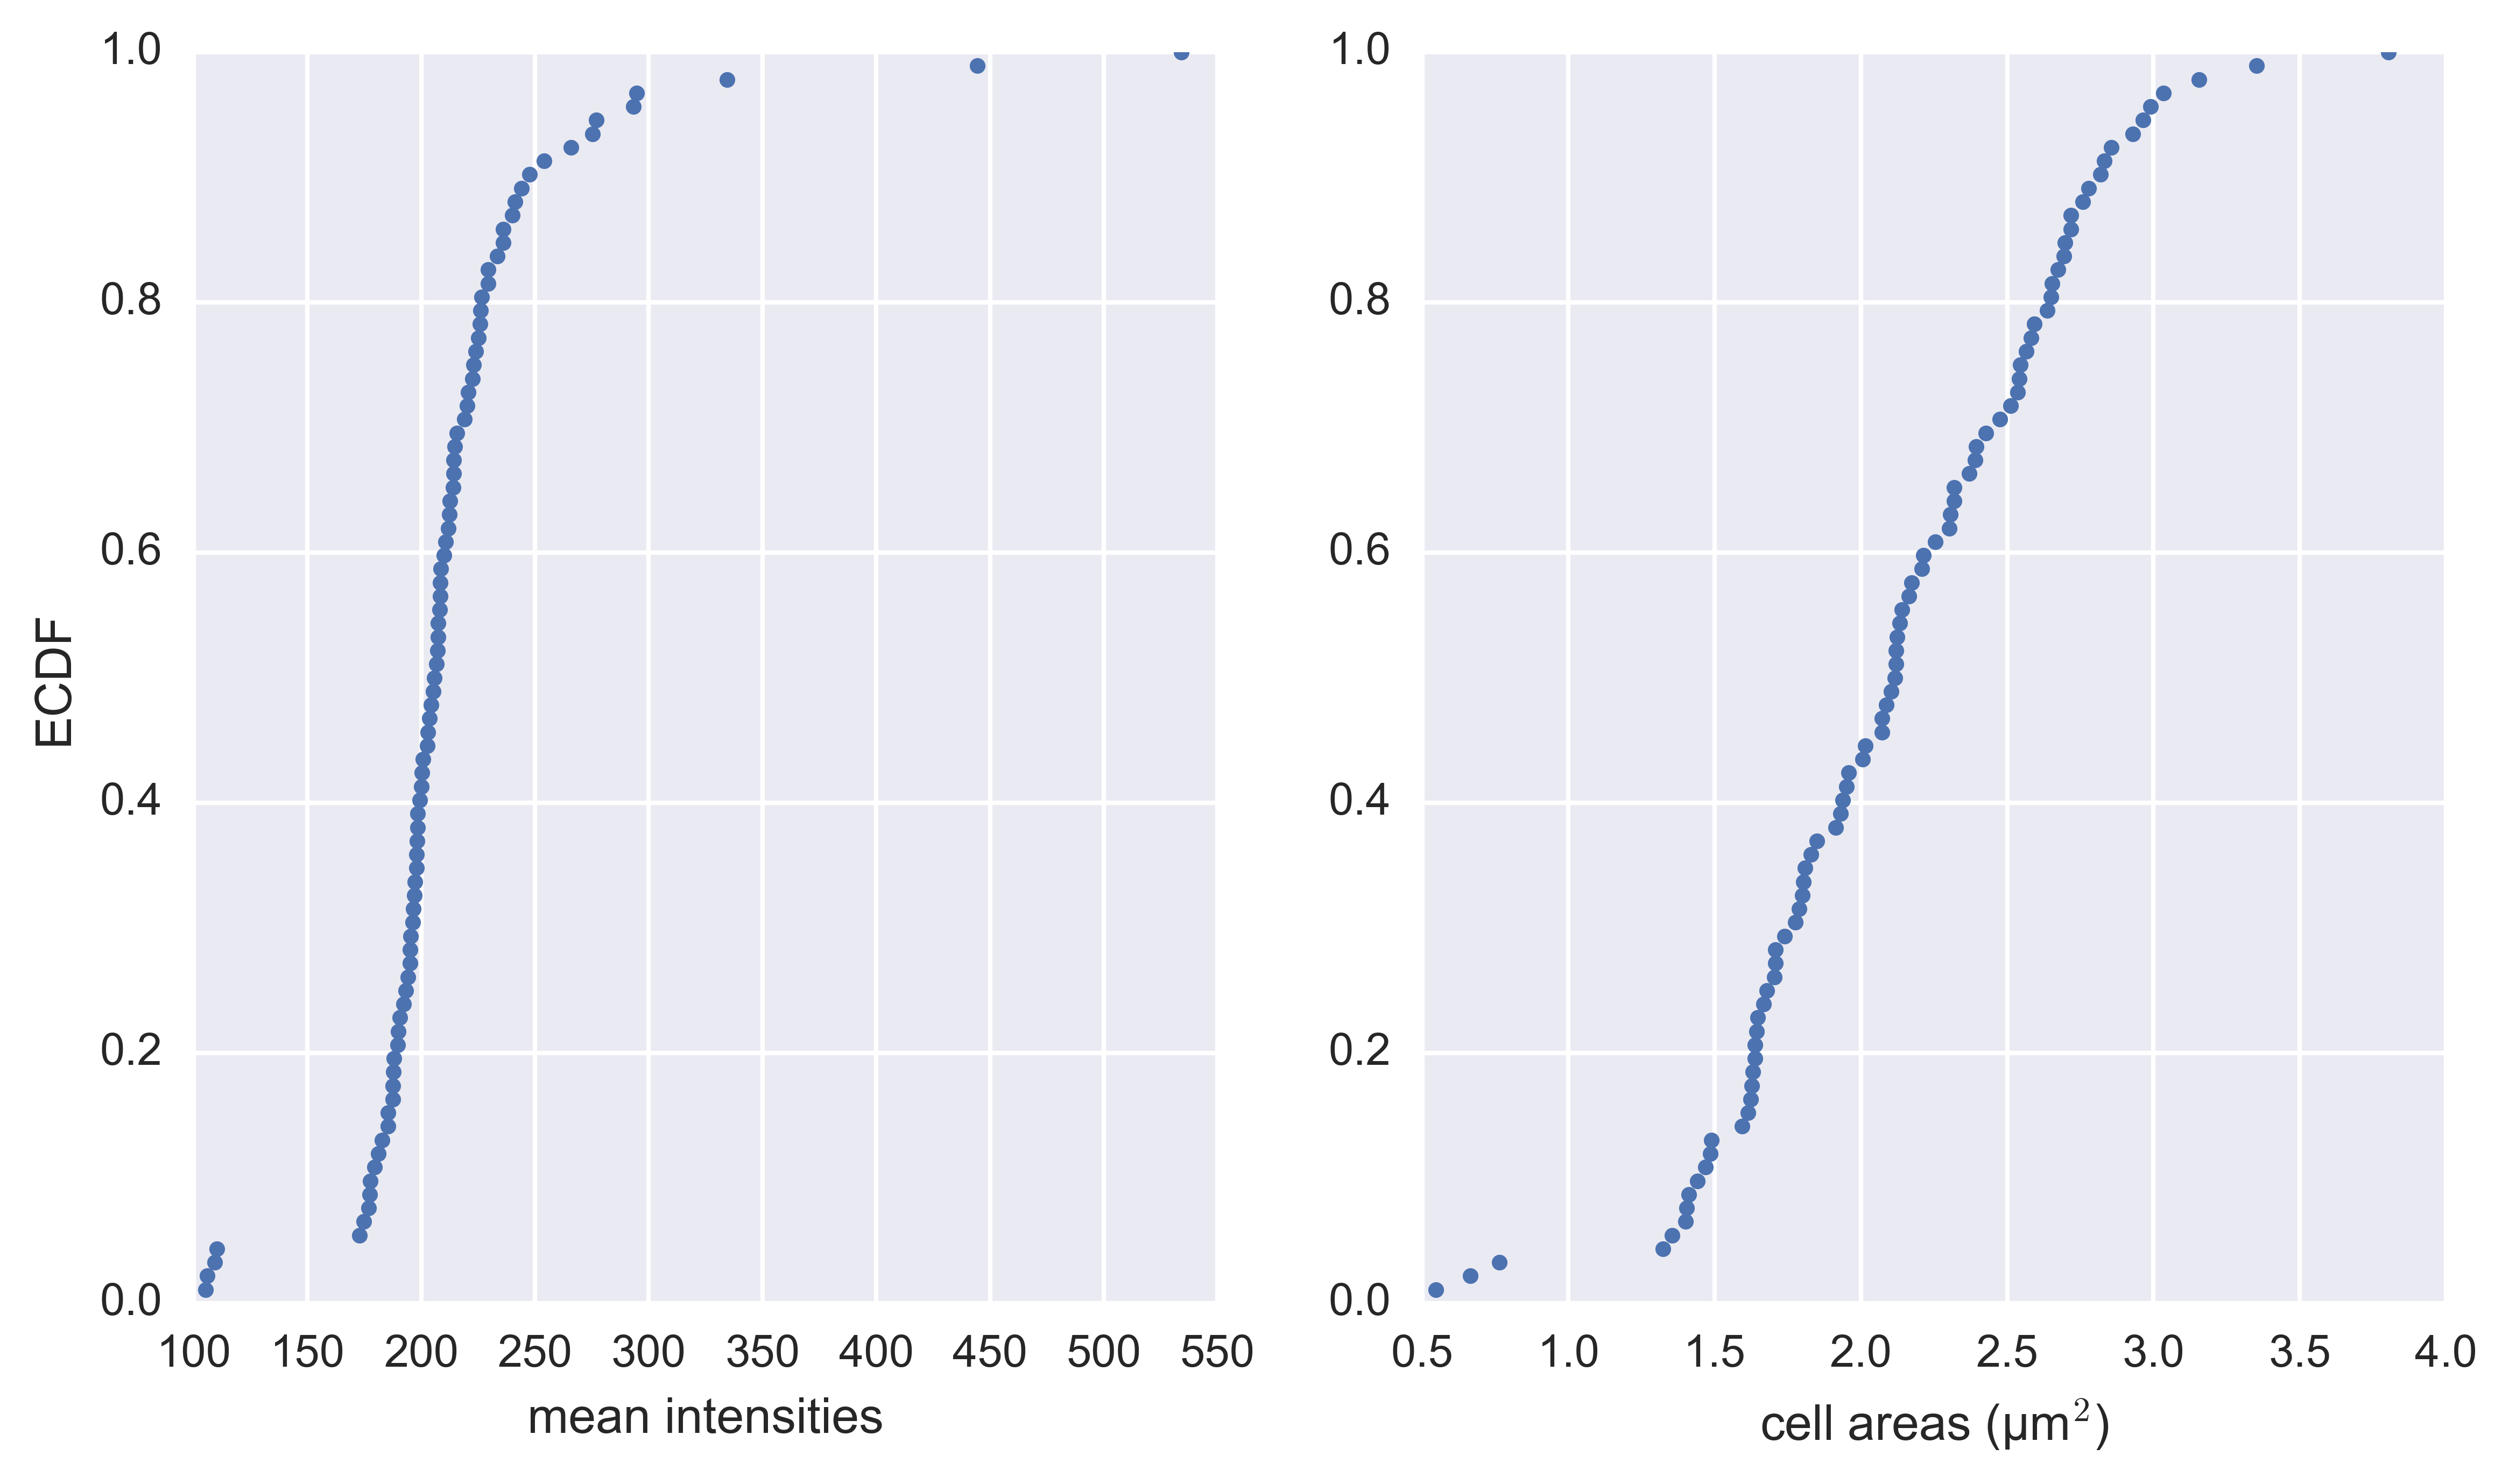

In [11]:
# Generate the ECDFs for the intensities and areas. 
means_sort, means_ecdf = ecdf(mean_ints)
areas_sort, areas_ecdf = ecdf(areas)

# Plot them.
fig, ax = plt.subplots(1,2, figsize=(9,5))
ax[0].plot(means_sort, means_ecdf, '.')
ax[0].set_xlabel('mean intensities')
ax[0].set_ylabel('ECDF')
ax[1].plot(areas_sort, areas_ecdf, '.')
ax[1].set_xlabel('cell areas (µm$^2$)')

The both appear to be gaussian-like. Let's go ahead and perform 1,000,000 *in silico* replicates of this experiment to get a confidence interval on our mean cell intensities.

In [12]:
# Set the number of repettitions. 
n_rep = 1000000

# Instantiate a vector to hold the bootstrap means. 
bs_means = np.empty(n_rep)

# Loop through and resample. 
for i in range(n_rep):
    bs_resample = np.random.choice(mean_ints, replace=True, size=len(mean_ints))
    bs_means[i] = np.mean(bs_resample)

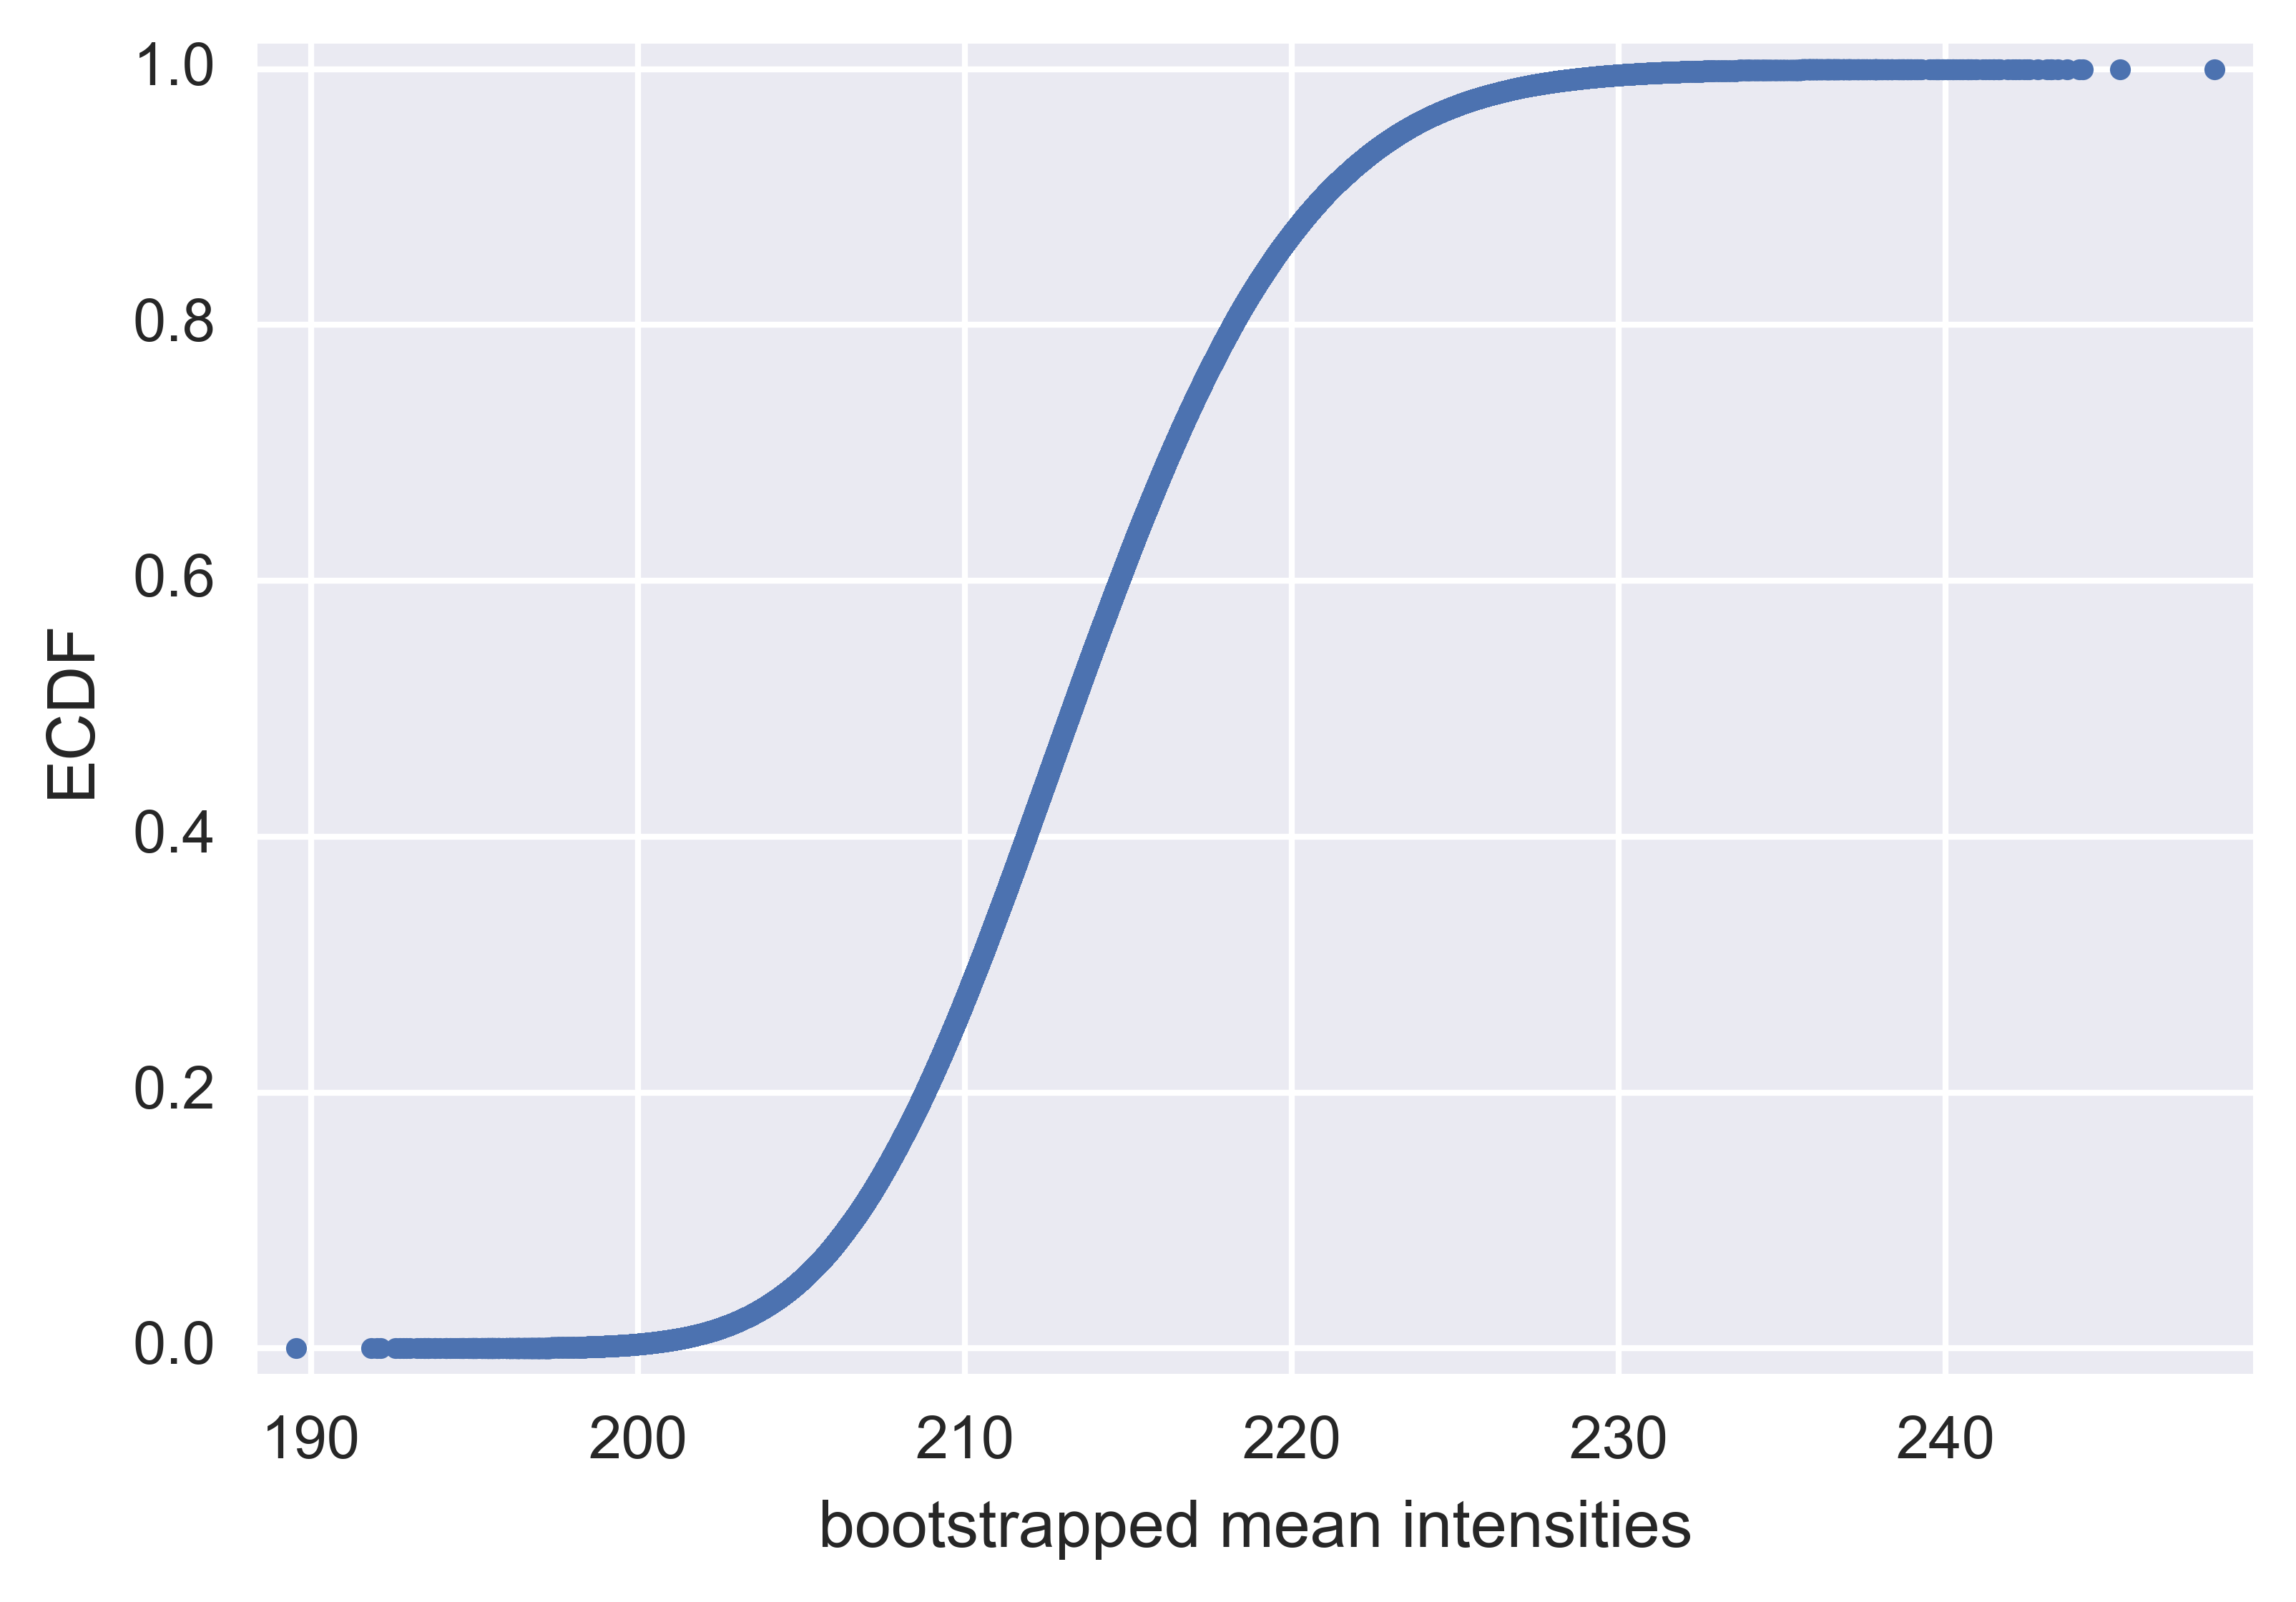

In [13]:
# Let's plot the ECDF
bs_means_sorted, bs_ecdf = ecdf(bs_means)
plt.plot(bs_means_sorted, bs_ecdf, '.')
plt.margins(0.02)
plt.xlabel('bootstrapped mean intensities')
plt.ylabel('ECDF')

That looks remarkably Normal (thanks to the central limit theorem). Let's compute and report our 95% confidence interval. 

In [15]:
# Compute the 97.5% and 2.5% percentiles.
percs = np.percentile(bs_means, [2.5, 97.5])

print('95% of our bootstrapped means lie between {0:.2f} and {1:.2f}.'.format(
                        percs[0], percs[1]))

95% of our bootstrapped means lie between 203.39 and 225.43.
